https://www.kaggle.com/code/brunods10/predicting-customer-churn-with-survival-analysis


In [ ]:
%pip install lifelines

In [ ]:
import re

import lifelines
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
from lifelines import CoxPHFitter, NelsonAalenFitter
from lifelines.plotting import plot_lifetimes
from sklearn import metrics, tree
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm

### Functions

In [ ]:
def calculate_vif(features):
    """
    Calculate VIF to see what features are highly correlated
    """
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return(vif)

In [ ]:
def ohe_dset(dset, categorical_columns, ohe):
    """
    Function to apply one hot encoding to a dataframe
    """
    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(
        input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [ ]:
def plot_mi_scores(scores):
    """
    Function to plot a Mutual information graph
    """
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
# Pie chart

def pie_chart(dset, name, threshold = 100):
    """
    Pie chart to examine all values or a percentage threshold
    """
    c_loc = dset.sort_values(by = name)
    c_loc = c_loc.groupby([name]).size().to_frame("Count").reset_index()
    c_loc["perc"] = c_loc["Count"]/dset.shape[0] * 100
    c_loc = c_loc.sort_values(by = "perc", ascending = False)
    c_loc["cum_perc"] = c_loc["perc"].cumsum()
    c_loc = c_loc.reset_index(drop=True)

    if threshold:
        c_loc = c_loc[c_loc.cum_perc <= threshold]

    my_circle = plt.Circle( (0,0), 0.7, color="white")

    plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = {"linewidth": 7, "edgecolor": "white"})
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [ ]:
# Data sub populations from tree model

def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]

    return rules, proba

In [ ]:
# Feature selection

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
# New interaction terms

def new_f(new_name, name, var, cvar):
    X_train[new_name] = 0
    X_train.loc[X_train[cvar] == name, new_name] = X_train[var]
    X_test[new_name] = 0
    X_test.loc[X_test[cvar] == name, new_name] = X_test[var]

In [ ]:
# Min-Max transformation

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [ ]:
# Compare box plots

def boxplot_compare(dset, target, var, num, target1, target2, title1, title2):
    fig, ax=plt.subplots(1, 2, figsize=(20, 7))
    d1 = dset[dset[target] == target1]
    d1 = d1.sort_values([var])
    d2 = df[df[target] == target2]
    d2 = d2.sort_values([var])
    g1 = sns.boxplot(data=d1,
                     x=num,
                     y=var,
                     hue=var,
                     palette="rainbow",
                     legend=False,
                     showmeans=True,
                     ax=ax[0])
    g1.set_title(title1)
    g1.set_xlim(0, max(dset[num]) + 10)

    g2 = sns.boxplot(data=d2,
                     x=num,
                     y=var,
                     hue=var,
                     palette="rainbow",
                     legend=False,
                     showmeans=True,
                     ax=ax[1])
    g2.set(ylabel=None)
    g2.set(yticklabels=[])
    g2.set_title(title2)
    g2.set_xlim(0, max(dset[num]) + 10)
    plt.show();

### Read in the data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Kaggles/Telco Customer Churn")
# Print out the current directory
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Kaggles/Telco Customer Churn


In [ ]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(data.shape)
data.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
print(list(data.columns))

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
nonvar_lst = []

for i in range(data.shape[1]):
    print('Column: ', data.columns[i], ', number of unique classes: ', data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print('Values: ', list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])



Column:  customerID , number of unique classes:  7043
Column:  gender , number of unique classes:  2
Values:  ['Male', 'Female']
Column:  SeniorCitizen , number of unique classes:  2
Values:  [0, 1]
Column:  Partner , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  Dependents , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  tenure , number of unique classes:  73
Column:  PhoneService , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  MultipleLines , number of unique classes:  3
Values:  ['Yes', 'No', 'No phone service']
Column:  InternetService , number of unique classes:  3
Values:  ['Fiber optic', 'DSL', 'No']
Column:  OnlineSecurity , number of unique classes:  3
Values:  ['Yes', 'No internet service', 'No']
Column:  OnlineBackup , number of unique classes:  3
Values:  ['Yes', 'No internet service', 'No']
Column:  DeviceProtection , number of unique classes:  3
Values:  ['Yes', 'No internet service', 'No']
Column:  TechSupport , number of uniqu

In [ ]:
print(nonvar_lst)

[]


### Missing data

In [ ]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/data.shape[0]*100
check

,Count,perc
customerID,0,0.0
gender,0,0.0
SeniorCitizen,0,0.0
Partner,0,0.0
Dependents,0,0.0
tenure,0,0.0
PhoneService,0,0.0
MultipleLines,0,0.0
InternetService,0,0.0
OnlineSecurity,0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Target variable

In [ ]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors='coerce')
data["TotalCharges"].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

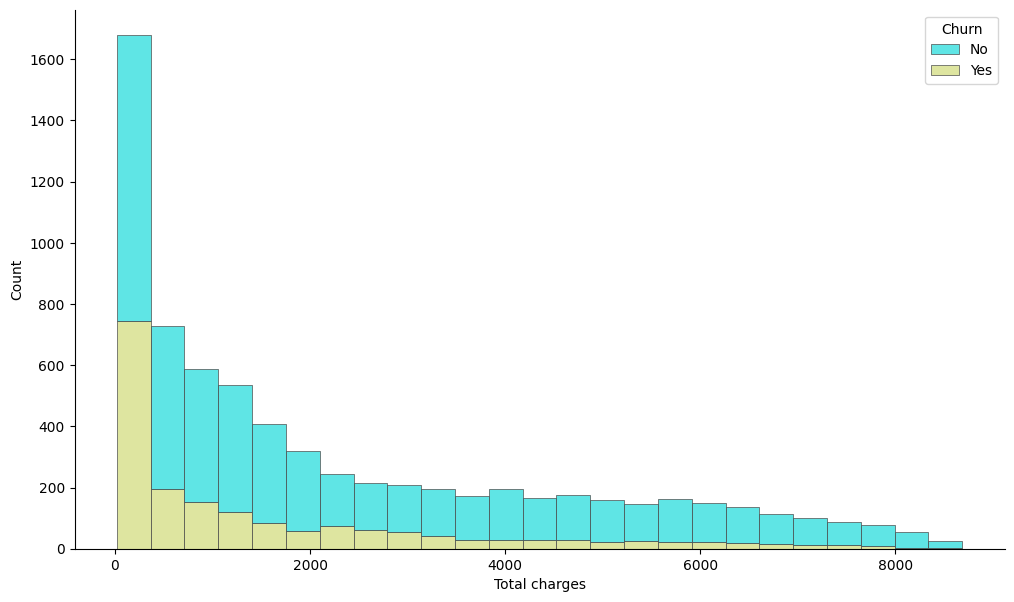

In [ ]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    data,
    x="TotalCharges",
    hue="Churn",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Total charges")
plt.show()

### Adjust the training set

In [ ]:
data = data.drop_duplicates()
print(data.shape)

(7043, 21)


In [ ]:
df = data.copy()

df = df[~df.TotalCharges.isna()]

for name in ["Partner","Dependents","PhoneService","PaperlessBilling","Churn"]:
    df[name + "_n"] = (df[name] == "Yes").astype(int)

df["gender_n"] = (df["gender"] == "Male").astype(int)

df.rename(columns={"SeniorCitizen": "SeniorCitizen_n"}, inplace = True)

for name in ["InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
             "Contract", "PaymentMethod"]:

    data[name] = data[name].str.replace("-","_")
    data[name] = data[name].str.replace(" ","_")
    data[name] = data[name].str.replace("(","")
    data[name] = data[name].str.replace(")","")

print(df.shape)
df.head()

(7032, 27)


,customerID,gender,SeniorCitizen_n,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Partner_n,Dependents_n,PhoneService_n,PaperlessBilling_n,Churn_n,gender_n
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Electronic check,29.85,29.85,No,1,0,0,1,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Mailed check,56.95,1889.50,No,0,0,1,0,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Mailed check,53.85,108.15,Yes,0,0,1,1,1,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Bank transfer (automatic),42.30,1840.75,No,0,0,0,0,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Electronic check,70.70,151.65,Yes,0,0,1,1,1,0


### Numerical data

In [ ]:
print([col for col in df.columns if "_n" in col])

['SeniorCitizen_n', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'Churn_n', 'gender_n']


In [ ]:
num_cols = list(df.select_dtypes(include=["number"], exclude=["datetime", "timedelta"]).columns)
num_cols = (list(set(num_cols) - set([col for col in df.columns if "_n" in col])))
print(num_cols)

['tenure', 'TotalCharges', 'MonthlyCharges']


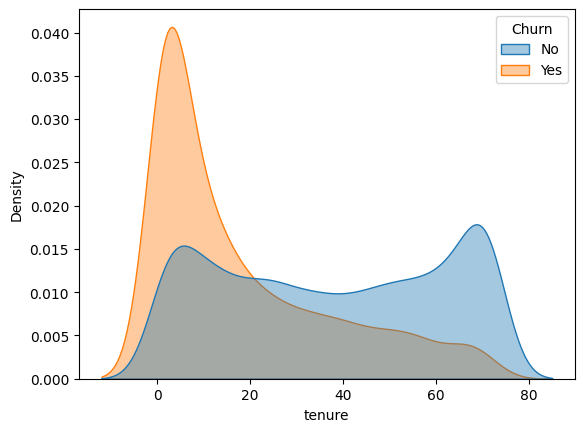

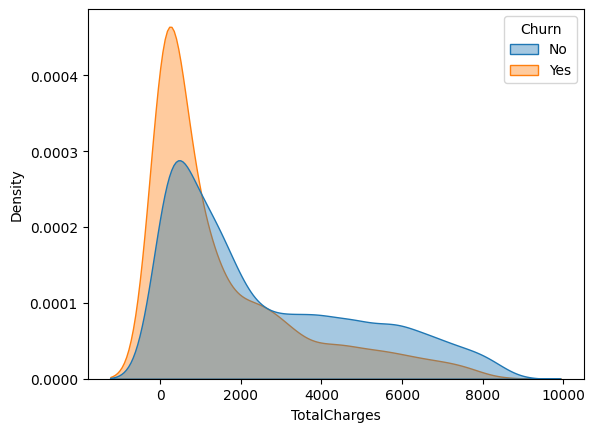

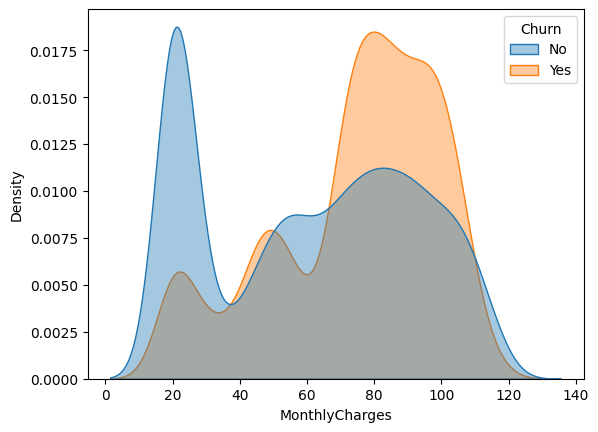

In [ ]:
for name in num_cols:
    sns.kdeplot(data=df, x=name, hue="Churn", fill=True, common_norm=False, alpha=0.4)
    plt.show()

### Interaction terms

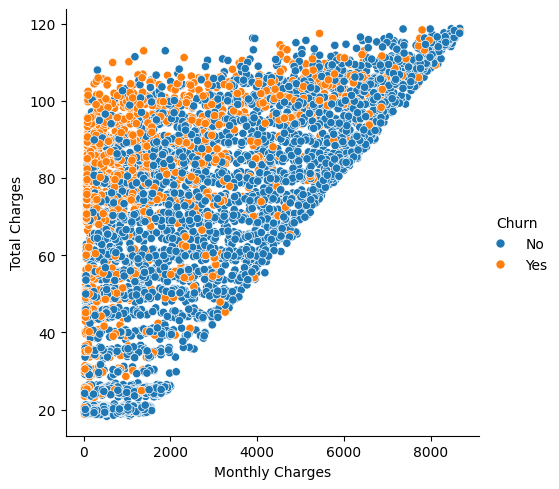

In [ ]:
sns.relplot(x="TotalCharges",
            y="MonthlyCharges",
            data = df,
            kind="scatter",
            hue="Churn")
plt.ylabel("Total Charges")
plt.xlabel("Monthly Charges")
plt.show()

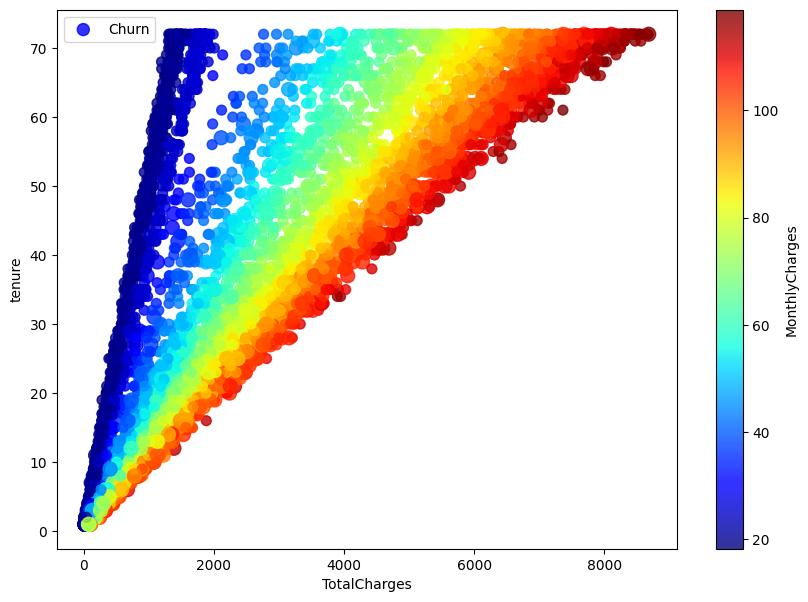

In [ ]:
data_v = df.copy()
data_v["Churn_n"] = (data_v["Churn_n"] + 1) * 50
data_v["Churn_n"] = data_v["Churn_n"].astype(int)

data_v.plot(kind="scatter",
            x="TotalCharges",
            y="tenure",
            alpha=0.8,
            s=data_v["Churn_n"],
            label="Churn",
            figsize=(10,7),
            c="MonthlyCharges",
            cmap=plt.get_cmap("jet"),
            colorbar=True,
            sharex=False)
plt.legend()
plt.show()

In [ ]:
# Contract              0.096910
# tenure                0.083345
# OnlineSecurity        0.063449
# TechSupport           0.061518
# InternetService       0.052963
# MonthlyCharges        0.049854
# PaymentMethod         0.048688
# OnlineBackup          0.046357

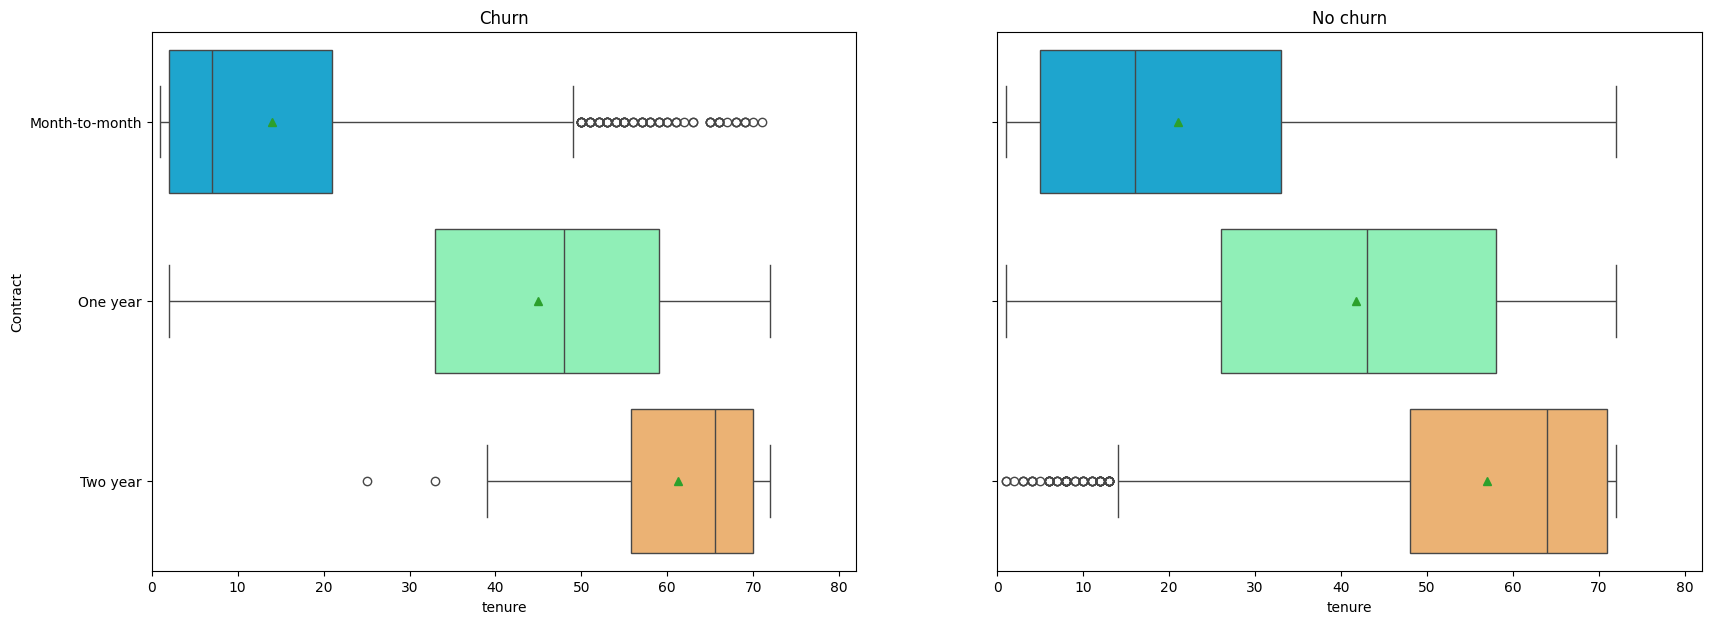

In [ ]:
boxplot_compare(df, "Churn", "Contract", "tenure", "Yes", "No", "Churn", "No churn")

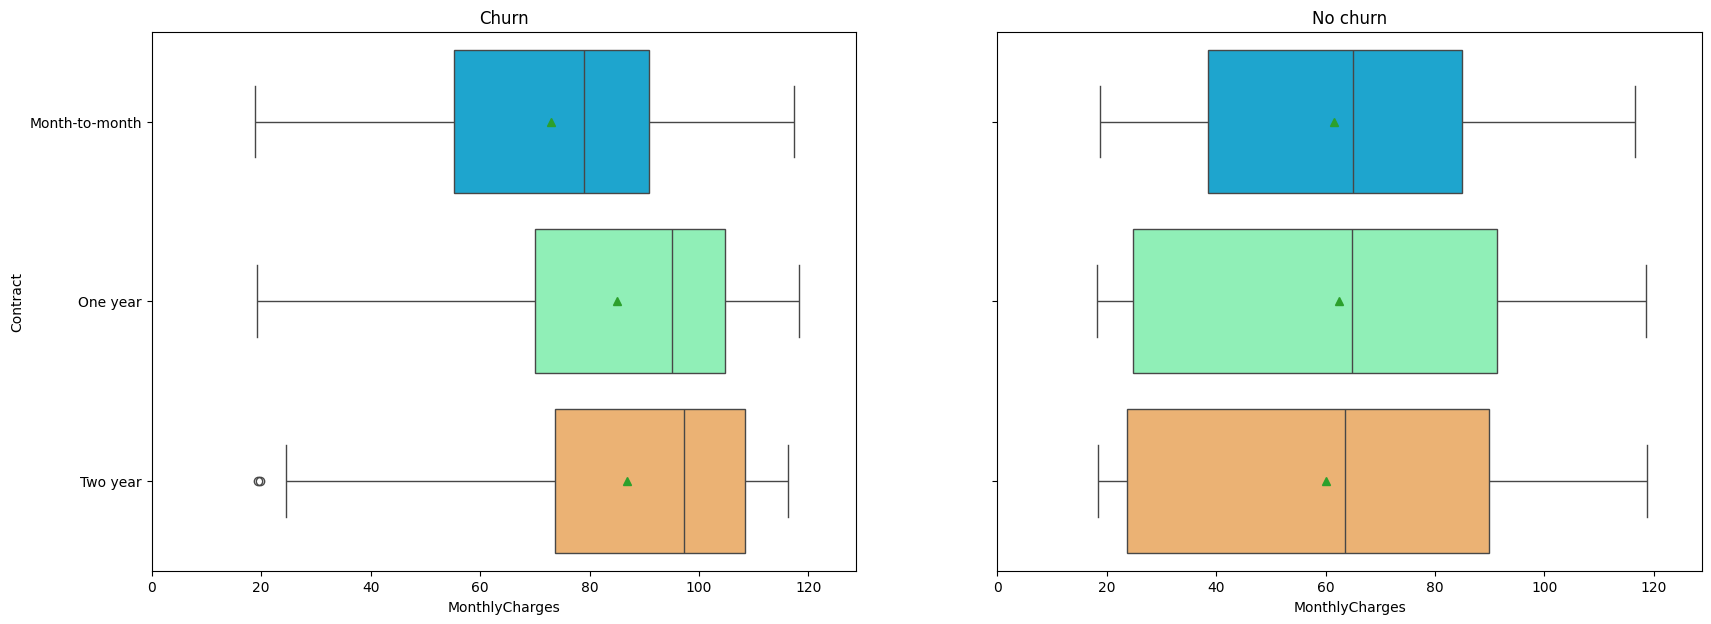

In [ ]:
boxplot_compare(df, "Churn", "Contract", "MonthlyCharges", "Yes", "No", "Churn", "No churn")


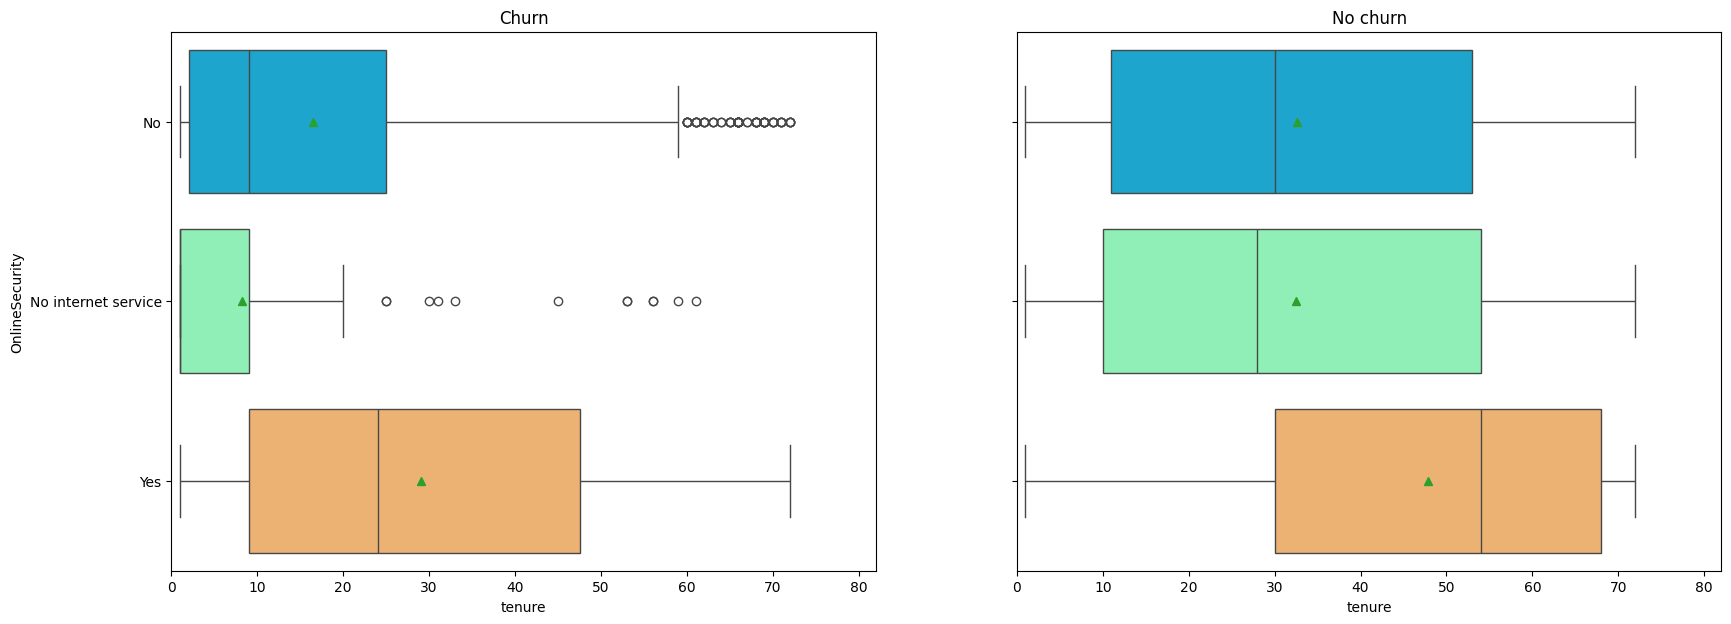

In [ ]:
boxplot_compare(df, "Churn", "OnlineSecurity", "tenure", "Yes", "No", "Churn", "No churn")


### Categorial data

In [ ]:
cat_cols = list(df.select_dtypes(include=['object']))
cat_cols.remove('customerID')
cat_cols.remove('Churn')
print(cat_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


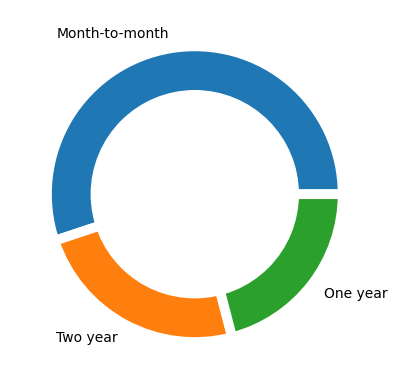

In [ ]:
pie_chart(df, "Contract")

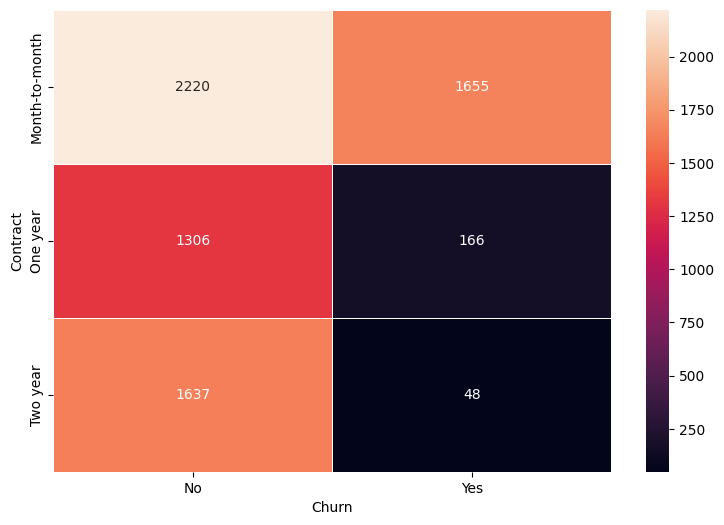

In [ ]:
data_a = df.groupby(["Contract", "Churn"]).size().reset_index()
data_a.columns = ["Contract", "Churn", "Count"]
data_a = data_a.pivot(index="Contract", columns="Churn", values="Count")

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="g", linewidths=.5, ax=ax)
fig.show()

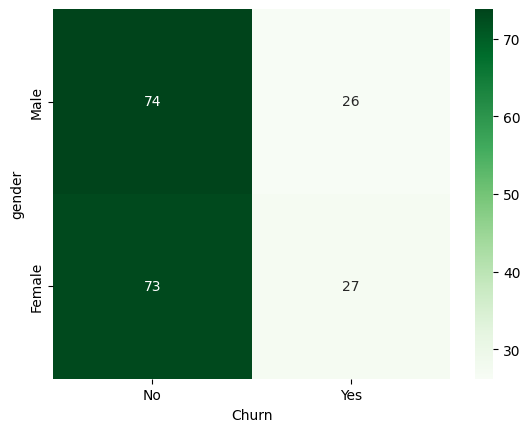

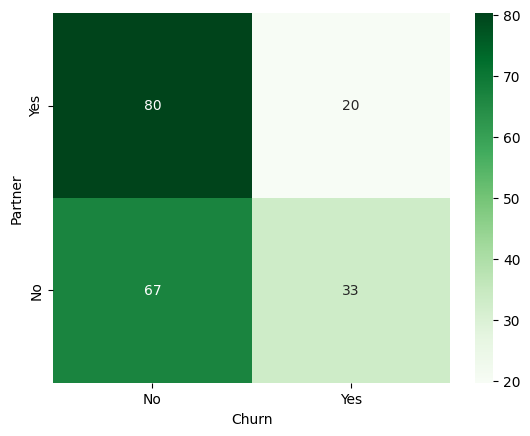

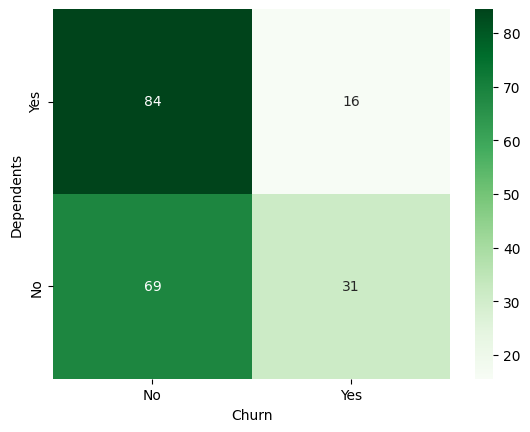

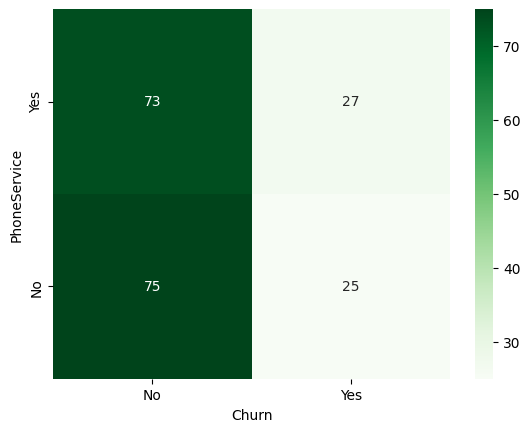

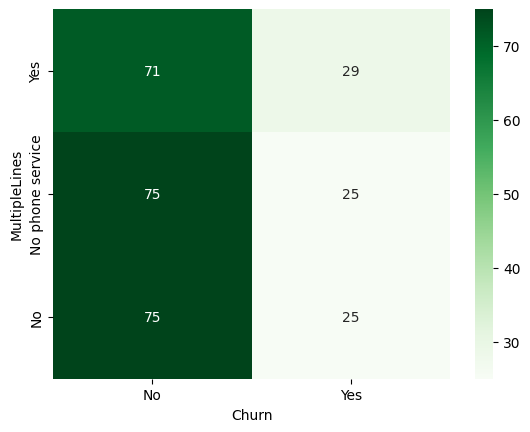

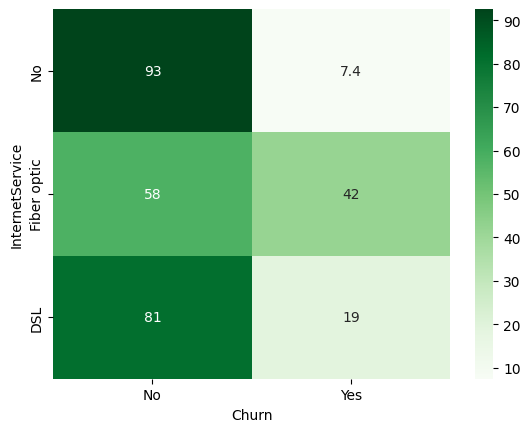

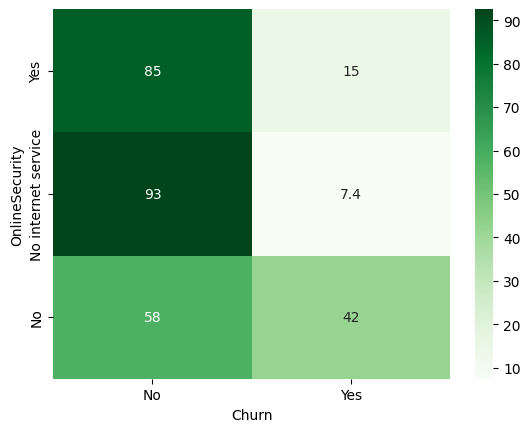

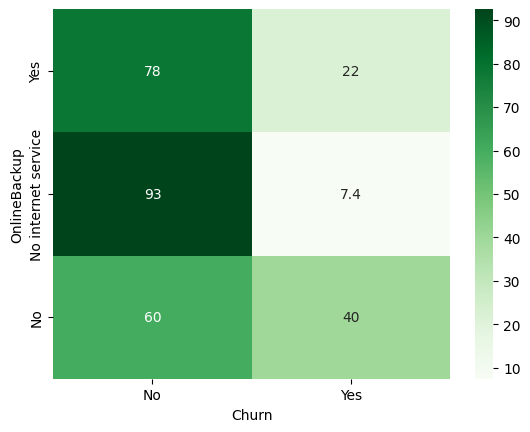

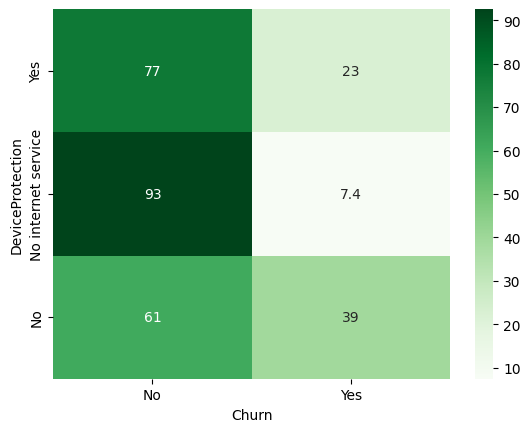

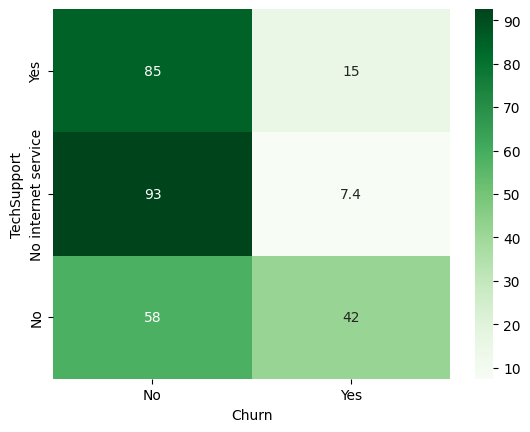

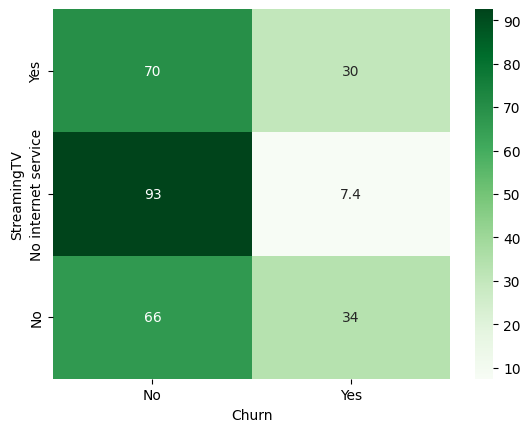

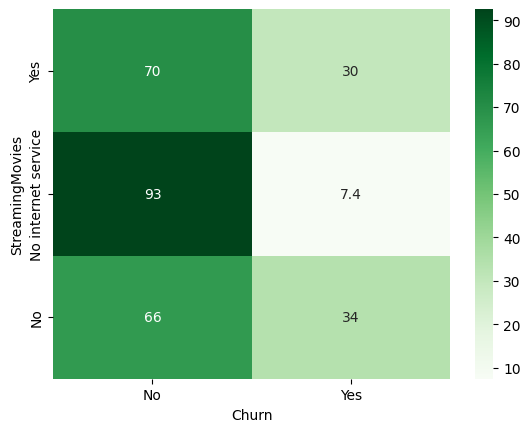

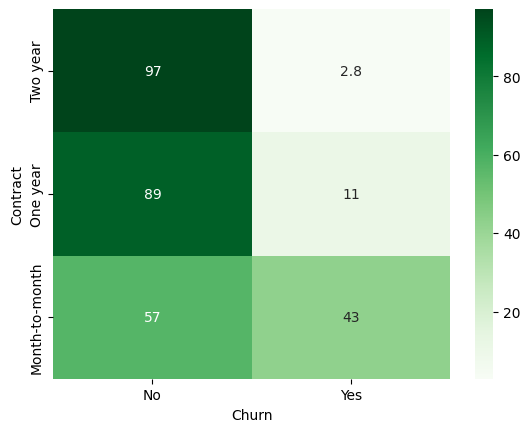

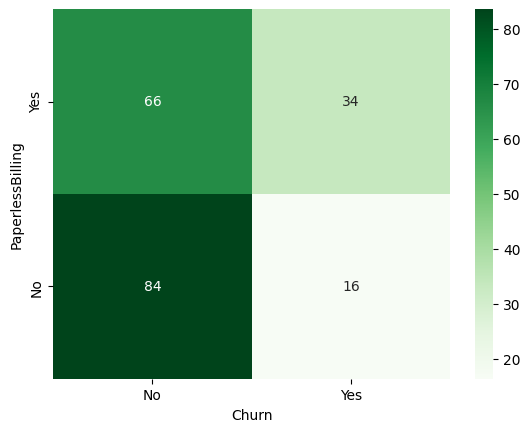

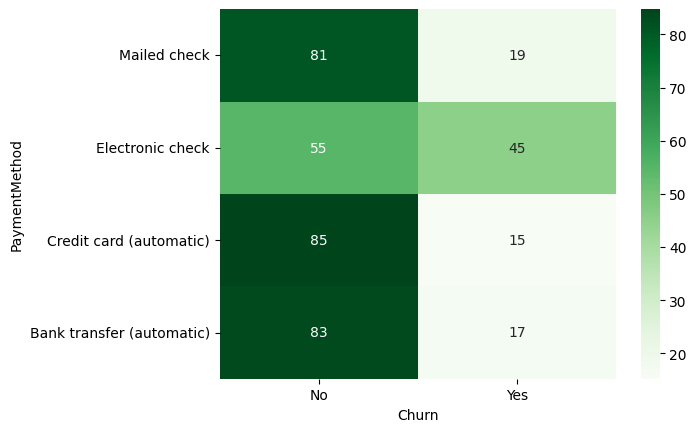

In [ ]:
for name in cat_cols:
    cross_tab = pd.DataFrame(pd.crosstab(df[name], df.Churn, normalize="index"))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

### Test/Train split

In [ ]:
conv_cols = [col for col in df.columns if "_n" in col]
drop_cols = [re.sub("_n", "", x) for x in conv_cols]
drop_cols.remove('SeniorCitizen')
print(drop_cols)

['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'gender']


In [ ]:
print(list(df.columns))

['customerID', 'gender', 'SeniorCitizen_n', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'Churn_n', 'gender_n']


In [ ]:
pd.crosstab(df.gender, columns = 'Count')

col_0,Count
gender,
Female,3483
Male,3549


In [ ]:
y = df.loc[:, ["tenure", "Churn"]]
y.columns = ["time", "status"]
y["status"] = y.loc[:, "status"] == "Yes"
X = df.drop(["Churn_n", "customerID", "tenure"] + drop_cols, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.4,
                                                    stratify = y,
                                                    random_state = 222)

print(X_train.shape, X_test.shape)
# (4219, 20) (2813, 20)

print("Churn rate train (%): ", round(y_train[y_train.status == 1].shape[0]/y_train.shape[0]*100,2))
print("Churn rate test (%): ", round(y_test[y_test.status == 1].shape[0]/y_test.shape[0]*100,2))

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_orig = X_train.copy()

(4219, 18) (2813, 18)
Churn rate train (%):  26.59
Churn rate test (%):  26.56


### Examine the features

In [ ]:
y = y_train.status.copy()
X = X_train.copy()

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

In [ ]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Contract              0.093972
OnlineSecurity        0.061710
TechSupport           0.058979
InternetService       0.055105
TotalCharges          0.053122
OnlineBackup          0.045891
PaymentMethod         0.043670
MonthlyCharges        0.041766
DeviceProtection      0.041010
StreamingMovies       0.029874
StreamingTV           0.029729
PaperlessBilling_n    0.020613
SeniorCitizen_n       0.013258
Dependents_n          0.013153
Partner_n             0.011636
MultipleLines         0.001067
PhoneService_n        0.000168
gender_n              0.000158
Name: MI Scores, dtype: float64

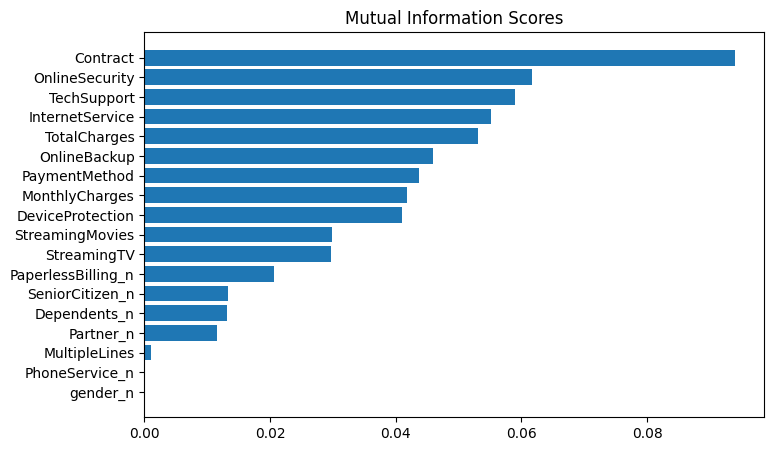

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.show();

### Features from tree classification

In [ ]:
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if ("_miss" in col) or ("feature_" in col)])))

X_train_b = pd.concat([X_train, y_train], axis = 1)

for m_val in num_cols:
    X_train_b[m_val + "_bin"], bin_edges  = pd.qcut(X_train_b[m_val],
                                                    q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                    retbins = True,
                                                    duplicates = "drop")
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train_b[m_val + "_bin"]  = pd.cut(X_train_b[m_val],
                                        bins = bin_edges,
                                        labels = range(len(bin_edges)-1),
                                        duplicates = "drop",
                                        include_lowest=True)
    X_train_b[m_val + "_bin"]  = X_train_b[m_val + "_bin"].astype(str)
    X_train_b.loc[X_train_b[m_val + "_bin"] == "nan",m_val + "_bin"] = "Missing"

Dependents_n [0. 1.] range(0, 1)
SeniorCitizen_n [0. 1.] range(0, 1)
PhoneService_n [0. 1.] range(0, 1)
gender_n [0. 1.] range(0, 1)
PaperlessBilling_n [0. 1.] range(0, 1)
Partner_n [0. 1.] range(0, 1)
MonthlyCharges [ 18.7   20.05  25.05  45.92  59.16  70.35  79.    85.58  94.27 102.46
 118.75] range(0, 10)
TotalCharges [  18.8    84.36  268.    561.55  965.23 1400.55 2021.26 3087.09 4444.67
 5958.09 8672.45] range(0, 10)


In [ ]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
print(cat_cols)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [ ]:
bin_m_data = [col for col in X_train_b.columns if "_bin" in col and "_miss_" not in col]
print(bin_m_data)

['Dependents_n_bin', 'SeniorCitizen_n_bin', 'PhoneService_n_bin', 'gender_n_bin', 'PaperlessBilling_n_bin', 'Partner_n_bin', 'MonthlyCharges_bin', 'TotalCharges_bin']


In [ ]:
X_train_b[bin_m_data + cat_cols].head()

,Dependents_n_bin,SeniorCitizen_n_bin,PhoneService_n_bin,gender_n_bin,PaperlessBilling_n_bin,Partner_n_bin,MonthlyCharges_bin,TotalCharges_bin,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod
0,0,0,0,0,0,0,6,6,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Electronic check
1,0,0,0,0,0,0,7,5,Yes,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Electronic check
2,0,0,0,0,0,0,8,7,Yes,Fiber optic,No,No,No,No,Yes,Yes,One year,Mailed check
3,0,0,0,0,0,0,6,2,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Electronic check
4,0,0,0,0,0,0,1,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Mailed check


In [ ]:
y = y_train.status
X = X_train_b[bin_m_data + cat_cols]

ohe = OneHotEncoder()

ohe.fit(X)
colnames = ohe.get_feature_names_out(list(X.columns))

bin_data_train = ohe_dset(X, list(X.columns), ohe)

(4219, 57)


In [ ]:
clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(bin_data_train, y)

text_representation = tree.export_text(clf, feature_names=list(bin_data_train.columns))

In [ ]:
rule_lst = []
flattened_lst = []
flattened_lsts = []

for split_size in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    X_trees, X_tree_test, y_trees, y_tree_test = train_test_split(bin_data_train,
                                                                  y,
                                                                  test_size = split_size,
                                                                  stratify = y,
                                                                  random_state = 222)
    print(X_trees.shape, y_trees.shape)

    model = clf.fit(X_trees, y_trees)
    text_representation = tree.export_text(clf, feature_names=list(X_trees.columns))
    rules, proba = get_rules(clf, list(X_trees.columns), [0,1], 60, 100)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

for i in range(len(flattened_lst)):
    flattened_lsts.append(flattened_lst[i].split(' then class')[0])
flattened_lsts = list(set(flattened_lsts))

  0%|          | 0/8 [00:00<?, ?it/s]

(3797, 57) (3797,)


NameError: name '_tree' is not defined

In [ ]:
flattened_lsts

[]

### New features

In [ ]:

for i, dset in enumerate([X_train, X_test]):

    dseta = dset.copy()
    dseta["feature_1"] = 0
    dseta.loc[(dseta.Contract != "Month_to_month") &
              (dseta.MonthlyCharges <= 93.775) &
              (dseta.OnlineSecurity != "No") &
              (dseta.MonthlyCharges > 65.4), "feature_1"] = 1

    dseta["feature_2"] = 0
    dseta.loc[(dseta.Contract != "Month_to_month") &
              (dseta.OnlineSecurity != "No") &
              (dseta.MonthlyCharges <= 65.275) &
              (dseta.TotalCharges > 31.525), "feature_2"] = 1

    dseta["feature_3"] = 0
    dseta.loc[(dseta.Contract != "Month_to_month") &
              (dseta.MonthlyCharges > 93.775) &
              (dseta.TotalCharges <= 8678.625) &
              (dseta.OnlineSecurity == "Yes"), "feature_3"] = 1

    dseta["feature_4"] = 0
    dseta.loc[(dseta.Contract != "Month_to_month") &
              (dseta.MonthlyCharges <= 93.775) &
              (dseta.OnlineSecurity == "No") &
              (dseta.MonthlyCharges > 35.1), "feature_4"] = 1

    dseta["feature_5"] = 0
    dseta.loc[(dseta.Contract != "Month_to_month") &
              (dseta.MonthlyCharges > 110.2), "feature_5"] = 1

    dseta["feature_6"] = 0
    dseta.loc[(dseta.Contract != "Month_to_month") &
              (dseta.MonthlyCharges > 93.95) &
              (dseta.MonthlyCharges <= 103.2), "feature_6"] = 1

    dseta["feature_7"] = 0
    dseta.loc[(dseta.Contract != "Month_to_month") &
              (dseta.MonthlyCharges <= 93.775) &
              (dseta.OnlineSecurity == "No") &
              (dseta.MonthlyCharges > 35.1), "feature_7"] = 1

    dseta["feature_8"] = 0
    dseta.loc[(dseta.Contract == "Month_to_month") &
              (dseta.InternetService == "Fiber optic") &
              (dseta.TotalCharges <= 95.725) &
              (dseta.PaymentMethod != "Credit card (automatic)"), "feature_8"] = 1

    dseta["feature_9"] = 0
    dseta.loc[(dseta.Contract == "Month_to_month") &
              (dseta.InternetService != "Fiber optic") &
              (dseta.PhoneService_n == 1), "feature_9"] = 1

    if i == 0:
        X_train = dseta
    elif i == 1:
        X_test = dseta

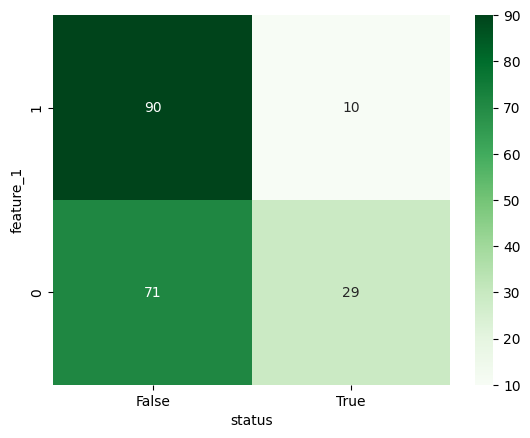

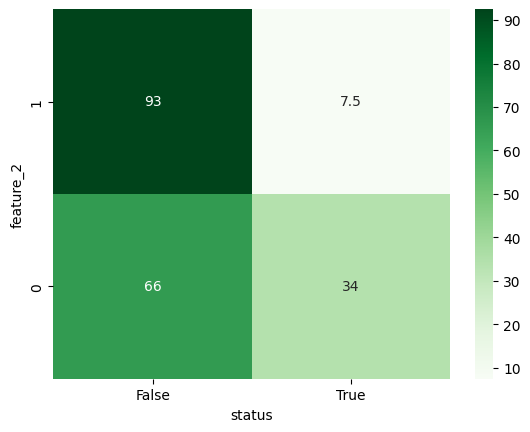

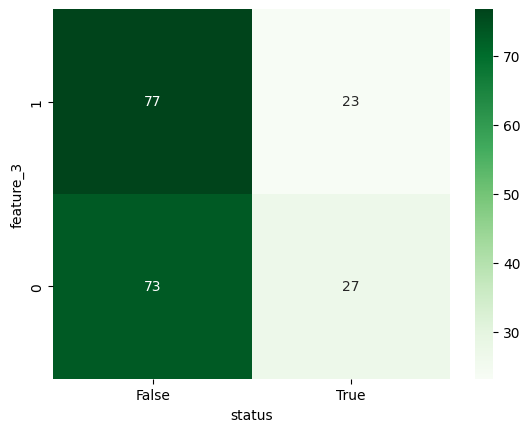

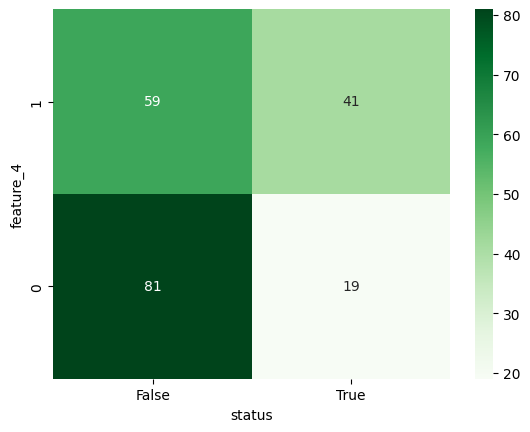

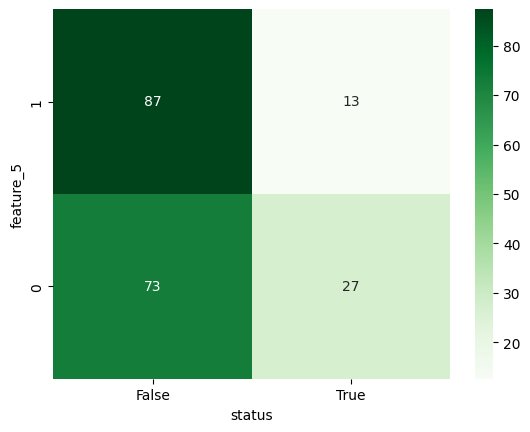

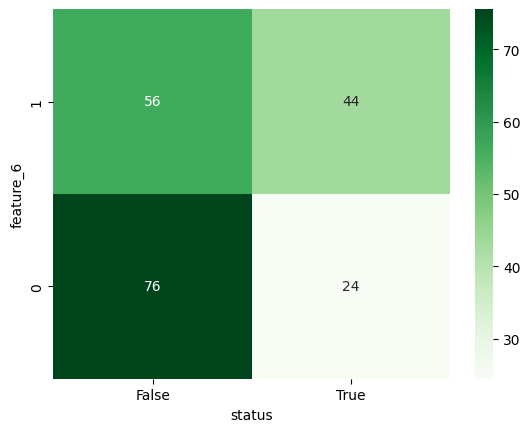

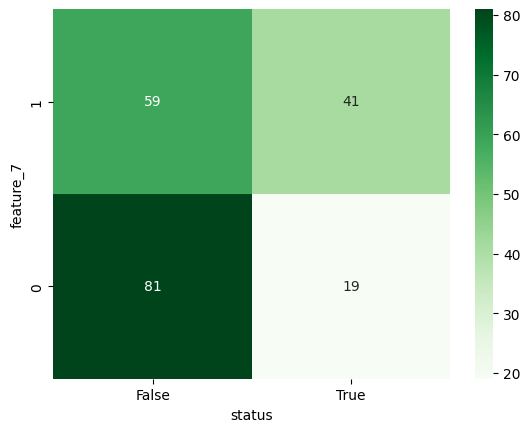

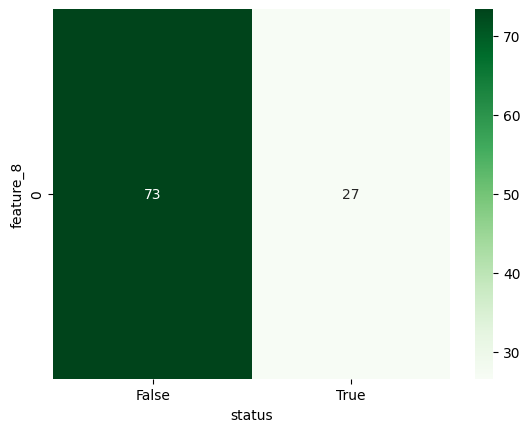

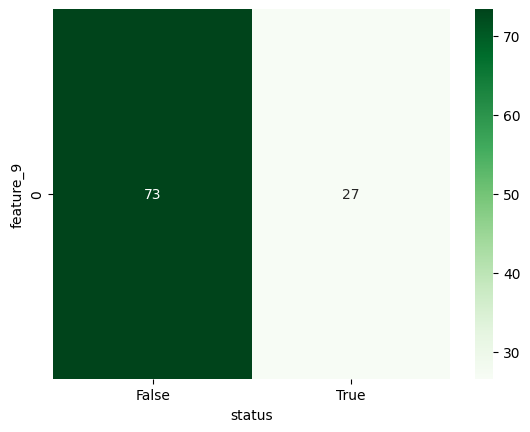

In [ ]:
for name in [col for col in X_train.columns if "feature_" in col]:
    cross_tab = pd.DataFrame(pd.crosstab(X_train[name], y_train.status, normalize="index"))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show()

### Binning data

In [ ]:
m_val_lst = ["MonthlyCharges"]

for m_val in m_val_lst:
    X_train[m_val + "_bin"], bin_edges = pd.qcut(X_train[m_val],
                                                 q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                 retbins = True,
                                                 duplicates = "drop")
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train[m_val + "_bin"] = pd.cut(X_train[m_val],
                                     bins = bin_edges,
                                     labels = range(len(bin_edges)-1),
                                     duplicates = "drop",
                                     include_lowest=True)
    X_train[m_val + "_bin"] = X_train[m_val + "_bin"].astype(str)
    X_train.loc[X_train[m_val + "_bin"] == "nan",m_val + "_bin"] = "Missing"

    # Test data
    X_test[m_val + "_bin"] = pd.cut(X_test[m_val],
                                    bins = bin_edges,
                                    labels = range(len(bin_edges)-1),
                                    include_lowest=True)

    X_test[m_val + "_bin"] = X_test[m_val + "_bin"].astype("str")
    X_test.loc[X_test[m_val + "_bin"] == "nan", m_val + "_bin"] = "Missing"


MonthlyCharges [ 18.7   20.05  25.05  45.92  59.16  70.35  79.    85.58  94.27 102.46
 118.75] range(0, 10)


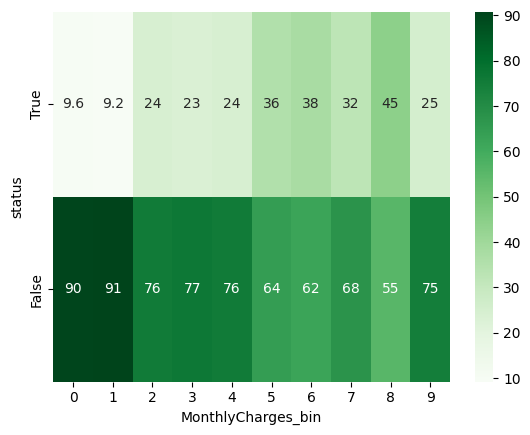

In [ ]:
pd.crosstab(X_train[m_val + "_bin"], columns="Count")

re_data = pd.concat([X_train,y_train.status], axis = 1)

room_t = pd.DataFrame(pd.crosstab(re_data["status"],
                                  re_data["MonthlyCharges_bin"],
                                  normalize="columns"))
room_t = room_t * 100

ax = sns.heatmap(room_t, annot = True, cmap="Greens")
ax.invert_yaxis()

### Preprocess the model data

In [ ]:
a = list(X_train.columns)
a.sort()
print(a)

X_train = X_train.drop(['MonthlyCharges'], axis = 1)
X_test = X_test.drop(['MonthlyCharges'], axis = 1)

['Contract', 'Dependents_n', 'DeviceProtection', 'InternetService', 'MonthlyCharges', 'MonthlyCharges_bin', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling_n', 'Partner_n', 'PaymentMethod', 'PhoneService_n', 'SeniorCitizen_n', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'TotalCharges', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'gender_n']


In [ ]:
# Check for single non varying data

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

['feature_8', 'feature_9']


In [ ]:
try:
    X_train = X_train.drop(lst, axis = 1)
    X_test = X_test.drop(lst, axis = 1)
except Exception:
    X_train = X_train
    X_test = X_test

In [ ]:
# Multicollinearity

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF < 10)]
to_keep_vif = list(a.Features)
print(to_keep_vif)
vif.sort_values(['VIF'], ascending = False)

['SeniorCitizen_n', 'TotalCharges', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'gender_n', 'feature_1', 'feature_2', 'feature_3', 'feature_5', 'feature_6']


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
10,feature_4,inf
13,feature_7,inf
4,PhoneService_n,7.556920
1,TotalCharges,3.539766
8,feature_2,2.768510
2,Partner_n,2.742720
5,PaperlessBilling_n,2.579060
7,feature_1,1.991673
3,Dependents_n,1.938420
6,gender_n,1.907521


In [ ]:
num_cols = list(X_train.select_dtypes(include=["number"], exclude=["datetime", "timedelta"]).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if ("_n" in col) or ("feature_" in col)])))
print(num_cols)

['TotalCharges']


[]


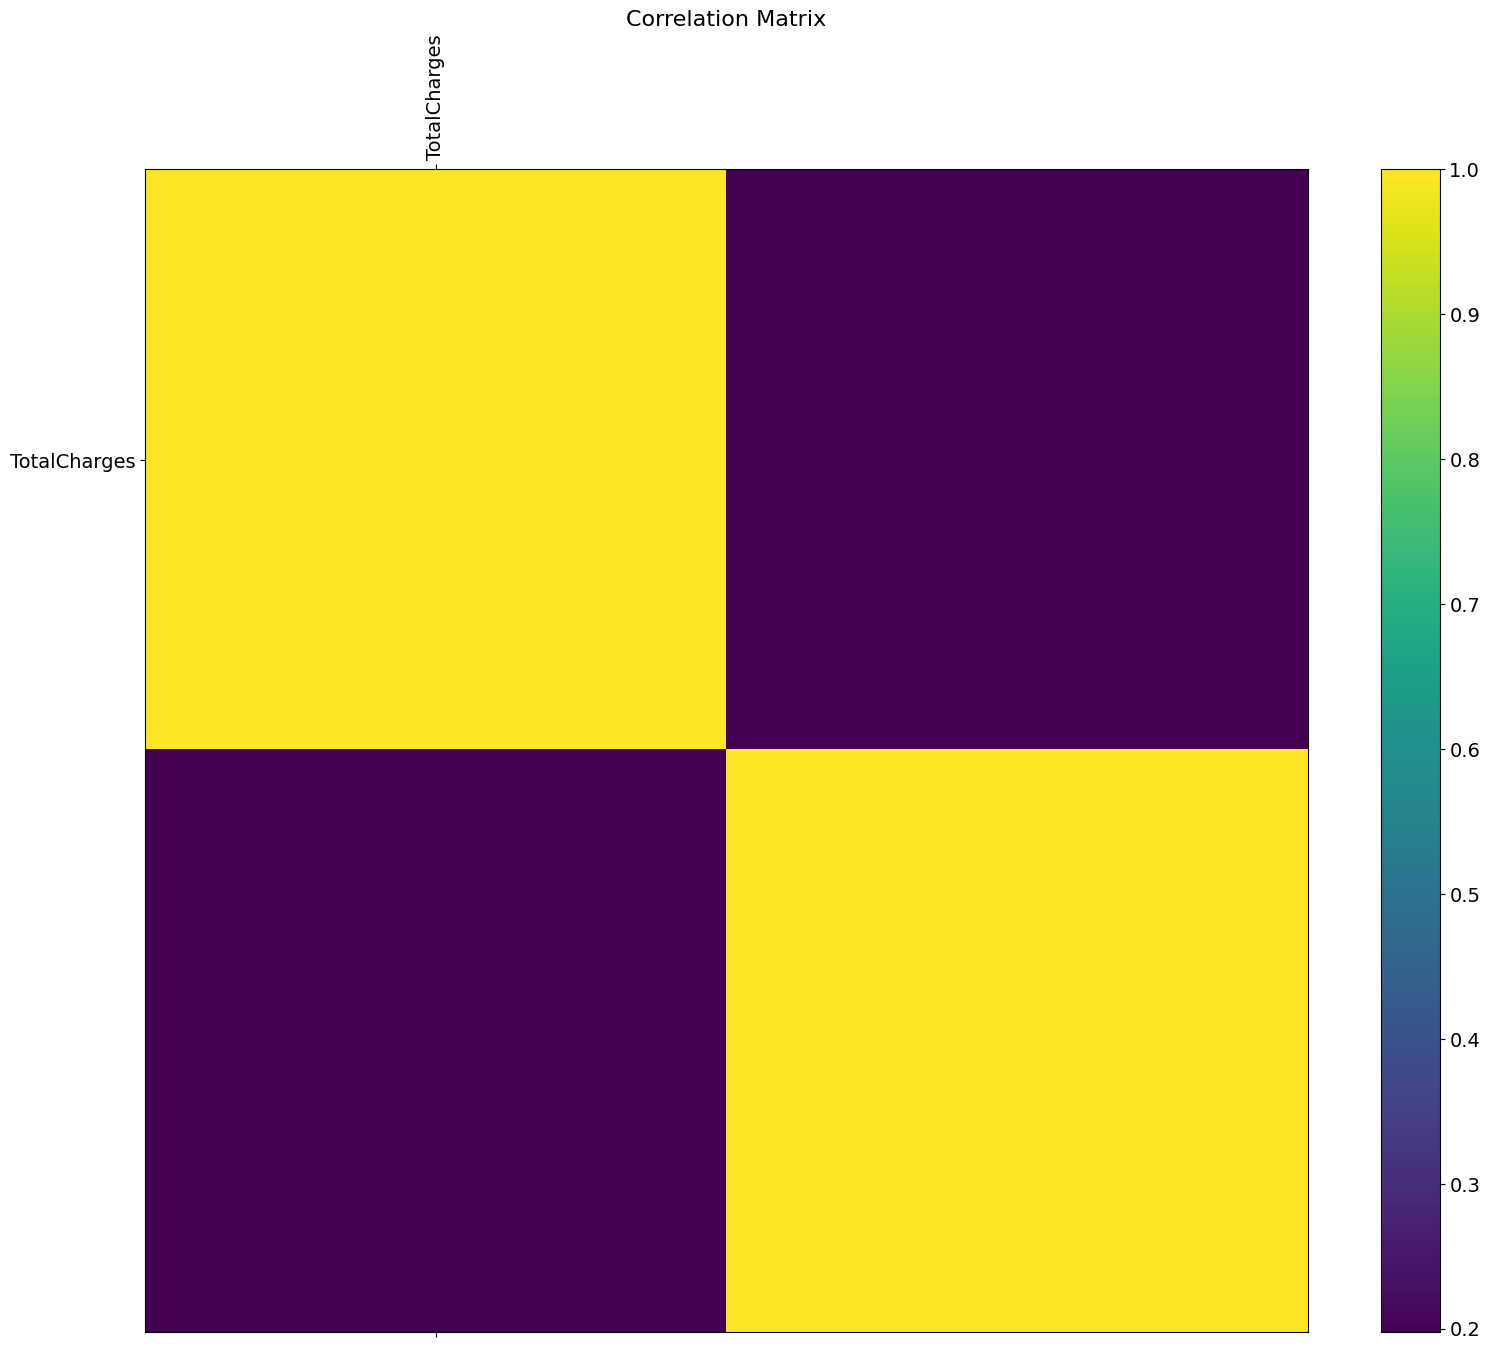

In [ ]:
# Correlation

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train.status)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(["number"]).shape[1]),
           corre_data.select_dtypes(["number"]).columns,
           fontsize=14,
           rotation=90)
plt.yticks(range(corre_data.select_dtypes(["number"]).shape[1]),
           corre_data.select_dtypes(["number"]).columns,
           fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [ ]:
# MinMax scaler

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) # Test

print(
    f'Data min:max {num_data_train.min().min(),num_data_train.max().max()}')

(4219, 1)
(4219, 1)
(2813, 1)
Data min:max (0.0, 0.9999999999999999)


In [ ]:
cat_cols = list(X_train.select_dtypes(include=["object"]))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if "_bin" in col])))

In [ ]:
# High cardinality adjustment

card_vars = []
cat_data = X_train[cat_cols]
cat_data_vals = cat_data.copy()
for i in range(cat_data.shape[1]):
    print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))
    if (len(list(set(cat_data.iloc[:,i]))) > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        cat_data_vals.loc[~cat_data_vals[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    elif cat_data.iloc[:,i].nunique() > 100:
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))
        card_vars.append(cat_data.columns[i])

print(card_vars)

InternetService 3
StreamingMovies 3
PaymentMethod 4
DeviceProtection 3
MultipleLines 3
StreamingTV 3
Contract 3
TechSupport 3
OnlineBackup 3
OnlineSecurity 3
[]


In [ ]:
# One hot encoding

ohe = OneHotEncoder()
print(X_train.shape)
# (357127, 56)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train, cat_cols, ohe)  # Train

for name in list(cat_data_train.columns):
    cat_data_train[name] = cat_data_train[name].astype(int)

cat_data_test = ohe_dset(X_test, cat_cols, ohe)    # Test

print(cat_data_train.shape)
cat_data_train.head()

print(
    f'Data min:max {cat_data_train.min().min(),cat_data_train.max().max()}')

(4219, 25)
(4219, 31)
(2813, 31)
(4219, 31)
Data min:max (0, 1)


In [ ]:
print([col for col in X_train.columns if '_bin' in col])

['MonthlyCharges_bin']


In [ ]:
ordinal_encoder_bin = OrdinalEncoder(categories=[["Missing","0","1","2","3","4","5","6","7","8","9"]])
ordinal_encoder_bin.fit(pd.DataFrame(X_train["MonthlyCharges_bin"]))
ord_data_train = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train["MonthlyCharges_bin"])),columns=["MonthlyCharges_bin"])
ord_data_test = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test["MonthlyCharges_bin"])), columns=["MonthlyCharges_bin"])

for name in ["MonthlyCharges_bin"]:
    ord_data_train[name] = ord_data_train[name].astype(int)

transformer_train_o = MinMaxScaler().fit(ord_data_train)
ord_data_train = pd.DataFrame(transformer_train_o.transform(ord_data_train))
ord_data_train.columns = ["MonthlyCharges_bin"]

print(
    f"Training data min:max {ord_data_train.min().min(),ord_data_train.max().max()}")

for name in ["MonthlyCharges_bin"]:
    ord_data_test[name] = ord_data_test[name].astype(int)

transformer_test_o = MinMaxScaler().fit(ord_data_test)
ord_data_test = pd.DataFrame(transformer_test_o.transform(ord_data_test))
ord_data_test.columns = ["MonthlyCharges_bin"]

print(
    f"Test data min:max {ord_data_test.min().min(),ord_data_test.max().max()}")

Training data min:max (0.0, 1.0)
Test data min:max (0.0, 1.0)


In [ ]:
print([col for col in X_train.columns if "_n" in col])
print([col for col in X_train.columns if "feature_" in col])
bin_data_train = X_train[[col for col in X_train.columns if "_n" in col] + [col for col in X_train.columns if "feature_" in col]]
bin_data_test = X_test[[col for col in X_train.columns if "_n" in col] + [col for col in X_train.columns if "feature_" in col]]

['SeniorCitizen_n', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'gender_n']
['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7']


In [ ]:
cat_data_train = cat_data_train[(list(set(list(cat_data_train.columns)) - set(["level_0", "index"])))]
num_data_train = num_data_train[(list(set(list(num_data_train.columns)) - set(["level_0", "index"])))]
ord_data_train = ord_data_train[(list(set(list(ord_data_train.columns)) - set(["level_0", "index"])))]
bin_data_train = bin_data_train[(list(set(list(bin_data_train.columns)) - set(["level_0", "index"])))]

cat_data_test = cat_data_test[(list(set(list(cat_data_test.columns)) - set(["level_0", "index"])))]
num_data_test = num_data_test[(list(set(list(num_data_test.columns)) - set(["level_0", "index"])))]
ord_data_test = ord_data_test[(list(set(list(ord_data_test.columns)) - set(["level_0", "index"])))]
bin_data_test = bin_data_test[(list(set(list(bin_data_test.columns)) - set(["level_0", "index"])))]

In [ ]:
print("Categorical data", list(cat_data_train.columns))
print("Numerical data", list(num_data_train.columns))
print("Ordinal data", list(ord_data_train.columns))
print("Binned data", list(bin_data_train.columns))

Categorical data ['DeviceProtection_No', 'StreamingMovies_No internet service', 'DeviceProtection_No internet service', 'Contract_One year', 'PaymentMethod_Bank transfer (automatic)', 'MultipleLines_No phone service', 'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No', 'TechSupport_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Mailed check', 'MultipleLines_No', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'OnlineSecurity_No internet service', 'Contract_Two year', 'OnlineBackup_No internet service', 'OnlineSecurity_Yes', 'PaymentMethod_Electronic check', 'Contract_Month-to-month', 'MultipleLines_Yes', 'StreamingTV_No internet service', 'PaymentMethod_Credit card (automatic)', 'OnlineBackup_No', 'StreamingMovies_Yes', 'TechSupport_No internet service', 'OnlineSecurity_No', 'InternetService_DSL', 'TechSupport_No']
Numerical data ['TotalCharges']
Ordinal data ['MonthlyCharges_bin']
Binned data ['Dependents_n', 'feature_5', 'SeniorCitizen_n', 'PhoneService_

In [ ]:
# Bring data together

print(cat_data_train.shape, num_data_train.shape, ord_data_train.shape, bin_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
ord_data_train = ord_data_train.reset_index()
bin_data_train = bin_data_train.reset_index()

X_train_mod = pd.concat([cat_data_train,num_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod, ord_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod, bin_data_train],axis = 1)
print(X_train_mod.shape)

print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
bin_data_test = bin_data_test.reset_index()
X_test_mod = pd.concat([cat_data_test, num_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod, ord_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod, bin_data_test],axis = 1)
print(X_test_mod.shape)

print(X_train_mod.shape, X_test_mod.shape)

(4219, 31) (4219, 1) (4219, 1) (4219, 13)
(4219, 50)
(2813, 31) (2813, 1) (2813, 13)
(2813, 49)
(4219, 50) (2813, 49)


In [ ]:
# Check that train/test sets have same columns

mod_cols = (list(set(list(X_train_mod.columns)) - set(['index'])))
X_train_mod = X_train_mod[mod_cols]
miss_lst = list(set(list(X_train_mod.columns)) - set(list(X_test_mod.columns)))

for name in miss_lst:
    X_test_mod[name] = 0
X_test_mod = X_test_mod[list(X_train_mod.columns)]

drop_test_lst = list(set(list(X_test_mod.columns)) - set(list(X_train_mod.columns)))
X_test_mod = X_test_mod.drop(drop_test_lst, axis = 1)


print(X_train_mod.shape, X_test_mod.shape)
# (64215, 105) (42811, 135) (10148, 107)


(4219, 46) (2813, 46)


### Lifetimes

Text(0.5, 1.0, 'Customer subscription lifelines')

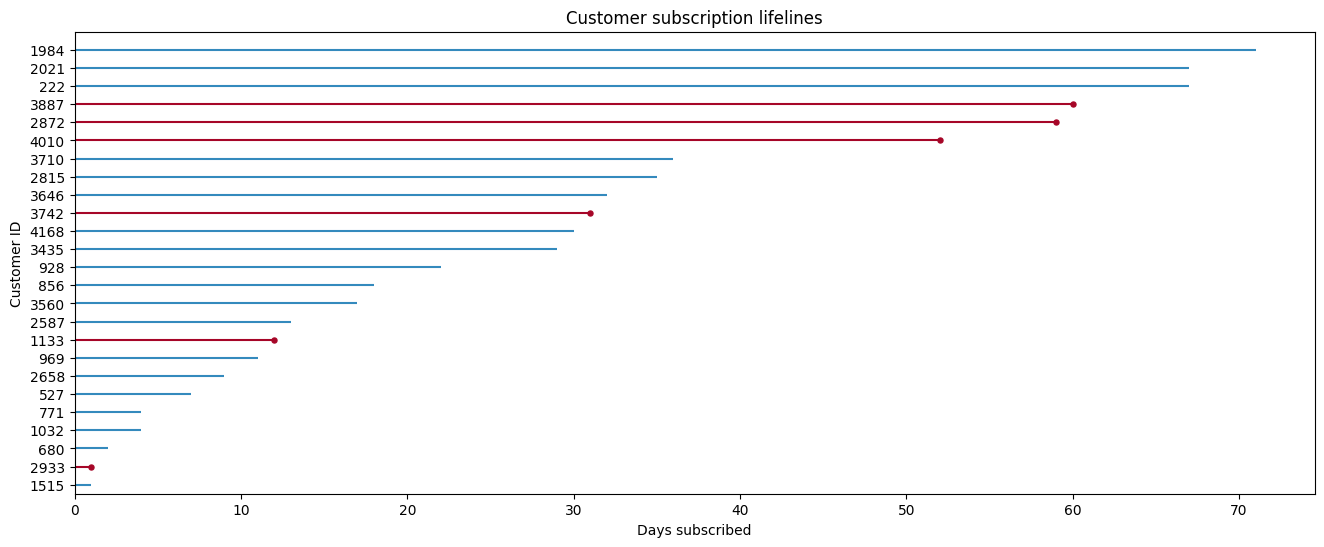

In [ ]:
time = y_train["time"].sample(25, replace=False)
status = y_train["status"].sample(25, replace=False)

plt.figure(figsize=(16, 6));
plot_lifetimes(time, status)
plt.xlabel("Days subscribed");
plt.ylabel("Customer ID");
plt.title("Customer subscription lifelines")

### Survival analysis

(0.0, 1.0)

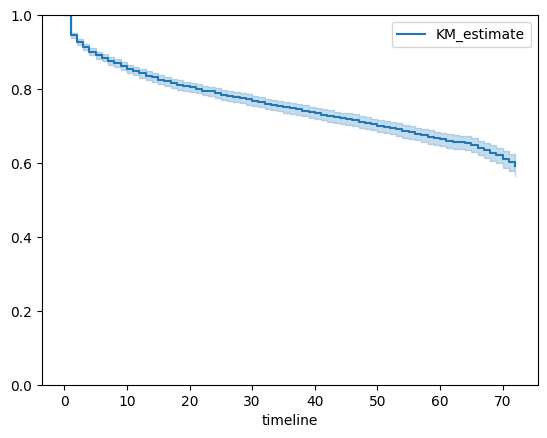

In [ ]:
T = y_train["time"]
E = y_train["status"]

kmf = lifelines.KaplanMeierFitter().fit(T, E, alpha=0.05)
kmf.plot_survival_function()
plt.ylim(0, 1)

In [ ]:
a = kmf.survival_function_
a = a.reset_index()
b = kmf.cumulative_density_
b = b.reset_index()
c = pd.merge(a,b,on = "timeline", how = "left")
c.columns = ["timeline","Cumulative KM estimate","KM estimate"]
c

,timeline,Cumulative KM estimate,KM estimate
0,0.0,1.000000,0.000000
1,1.0,0.945959,0.054041
2,2.0,0.927781,0.072219
3,3.0,0.913770,0.086230
4,4.0,0.901039,0.098961
...,...,...,...
68,68.0,0.627615,0.372385
69,69.0,0.620611,0.379389
70,70.0,0.609500,0.390500
71,71.0,0.601857,0.398143


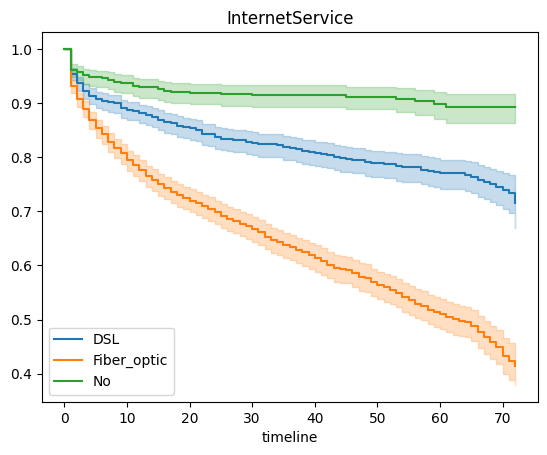

In [ ]:
ax = plt.subplot(111)

group = "InternetService"
for name, df in X_train.groupby(group):
    idx = X_train[group] == name
    kmf = lifelines.KaplanMeierFitter().fit(T[idx], E[idx], alpha=0.05, label=name)
    kmf.plot_survival_function(ax=ax)
plt.title(group)

In [ ]:
from lifelines.statistics import logrank_test

train_data = pd.concat([X_train, y_train], axis=1)
X_train_dsl = train_data[train_data["InternetService"] == "DSL"]
X_train_fo = train_data[train_data["InternetService"] == "Fiber_optic"]

results = logrank_test(X_train_dsl["time"],
                       X_train_fo["time"],
                       X_train_dsl["status"],
                       X_train_fo["status"], alpha=.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 0
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic   p  -log2(p)
           0.00 NaN       NaN

### Nelson-Aalen estimator

In [ ]:
naf = NelsonAalenFitter(alpha=0.05, nelson_aalen_smoothing=False).fit(T, E)
naf.cumulative_hazard_.head()

,NA_estimate
timeline,
0.0,0.000000
1.0,0.054041
2.0,0.073257
3.0,0.088360
4.0,0.102291


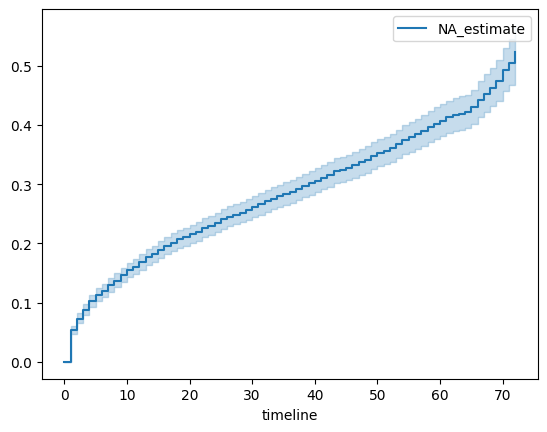

In [ ]:
naf.plot()
plt.show()

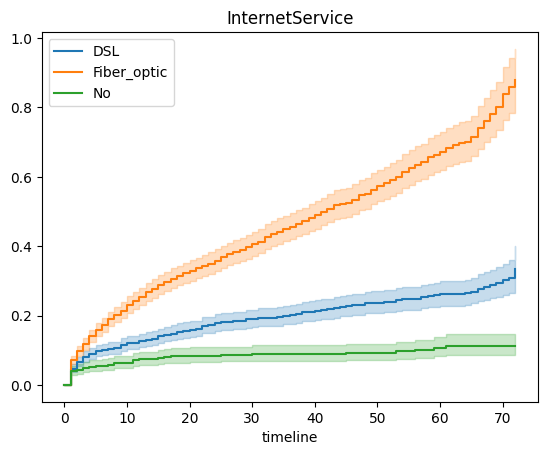

In [ ]:
ax = plt.subplot(111)

group = "InternetService"
for name, df in X_train.groupby(group):
    idx = X_train[group] == name
    naf = NelsonAalenFitter().fit(T[idx], E[idx], label=name)
    naf.plot(ax=ax)
plt.title(group)
plt.show()

### Hazard rate

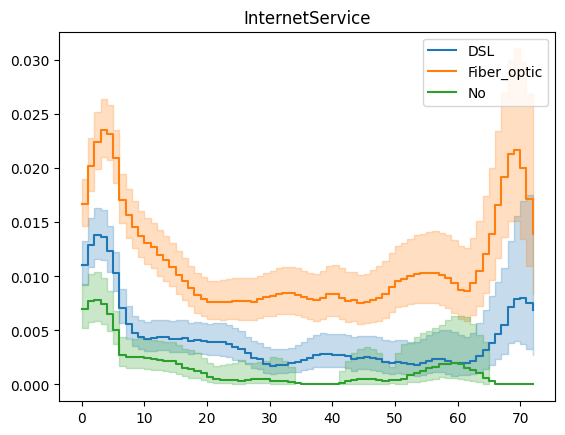

In [ ]:
ax = plt.subplot(111)

group = "InternetService"
for name, df in X_train.groupby(group):
    idx = X_train[group] == name
    naf = NelsonAalenFitter().fit(T[idx], E[idx], label=name)
    naf.plot_hazard(ax=ax, bandwidth=5)

plt.title(group)
plt.show()

### Cox Proportional Hazards Regression

In [ ]:
train_data = pd.concat([X_train_mod, y_train], axis=1)

cph = CoxPHFitter()
cph.fit(train_data,
        duration_col="time",
        event_col="status")
cph.print_summary()

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [ ]:
to_keep_vif.extend(["time", "status"])

cph = CoxPHFitter()
cph.fit(train_data.loc[:, to_keep_vif],
        duration_col="time",
        event_col="status")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4219 total observations, 3097 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 4219
number of events observed = 1122
   partial log-likelihood = -7322.12
         time fit was run = 2024-04-17 13:45:06 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
SeniorCitizen_n      0.39       1.48       0.07             0.25             0.53                 1.28                 1.70
TotalCharges       -12.18       0.00       0.37           -12.90           -11.46                 0.00                 0.00
Partner_n           -0.21       0.81       0.07            -0.35            -0.07                 0.70                 0.93
Dependents_n        -0.21       0.81       0.09            -0.38            -0.04                 0.68                 0.96
PhoneService_n       1.40       4.07       0.12             1.17             1.63                 3.23                 5.12
PaperlessBilling_n   0.51       1.66       0.07             0.36             0.65                 1.44                 1.91
gender_n            -0.06       0.94       0.06            -0.18             0.05                 0.83                 1.06
feature_1           -0.96       0.38       0.15            -1.26            -0.67                 0.28                 0.51
feature_2           -4.37       0.01       0.16            -4.69            -4.05                 0.01                 0.02
feature_3            0.52       1.69       0.14             0.25             0.79                 1.29                 2.20
feature_5            1.85       6.34       0.29             1.29             2.41                 3.62                11.11
feature_6            0.65       1.91       0.09             0.47             0.82                 1.60                 2.28

                     cmp to      z      p   -log2(p)
covariate                                           
SeniorCitizen_n        0.00   5.47 <0.005      24.43
TotalCharges           0.00 -33.02 <0.005     792.09
Partner_n              0.00  -2.95 <0.005       8.31
Dependents_n           0.00  -2.39   0.02       5.88
PhoneService_n         0.00  11.92 <0.005     106.42
PaperlessBilling_n     0.00   6.96 <0.005      38.14
gender_n               0.00  -1.06   0.29       1.79
feature_1              0.00  -6.36 <0.005      32.21
feature_2              0.00 -26.93 <0.005     528.39
feature_3              0.00   3.83 <0.005      12.92
feature_5              0.00   6.45 <0.005      33.05
feature_6              0.00   7.17 <0.005      40.31
---
Concordance = 0.92
Partial AIC = 14668.25
log-likelihood ratio test = 2999.73 on 12 df
-log2(p) of ll-ratio test = inf

### Plotting coefficiencts

<Axes: >

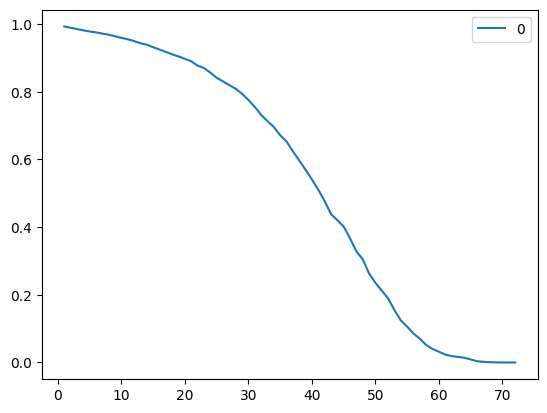

In [ ]:
cph.predict_survival_function(train_data.loc[:, to_keep_vif].loc[0]).plot()

<Axes: >

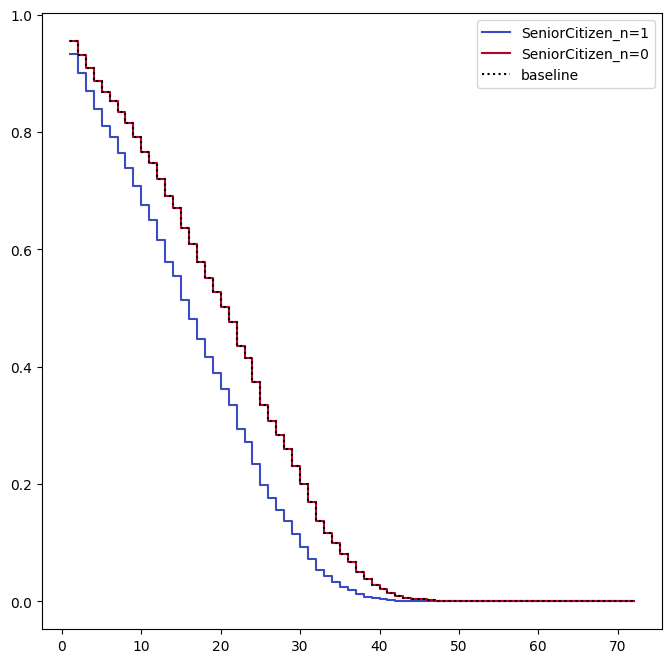

In [ ]:
cph.plot_partial_effects_on_outcome(covariates="SeniorCitizen_n",
                                    values=[1, 0],
                                    cmap='coolwarm',
                                    figsize = (8,8))

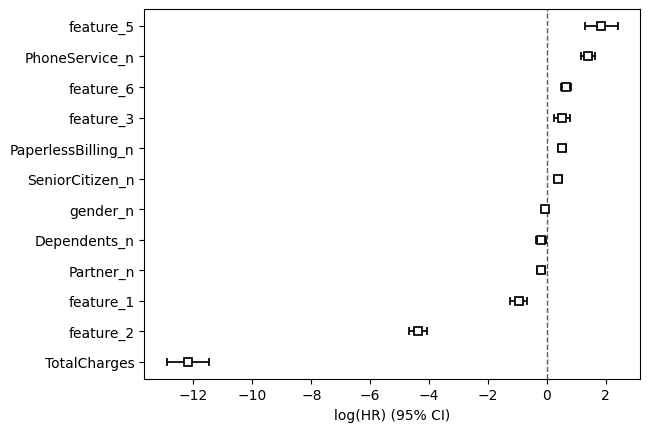

In [ ]:
cph.plot()
plt.show()

In [ ]:
surv_pred_train = cph.predict_survival_function(train_data)
surv_median_pred_train = cph.predict_median(train_data)

In [ ]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.945959
2.0,0.927781
3.0,0.913770
4.0,0.901039
...,...
68.0,0.627615
69.0,0.620611
70.0,0.609500


In [ ]:
fig = go.Figure()

buttons = []

fig.add_trace(
    go.Scatter(x=kmf.survival_function_.index,
               y=kmf.survival_function_["KM_estimate"],
               marker_color="black",
               name="KM estimate"
    )
)
buttons.append(dict(method="restyle",
                    label="KM Estimate",
                    args=[{"y": [kmf.survival_function_["KM_estimate"].values]}]))

for customerID in surv_pred_train.columns[0:50]:
    color = "red" if train_data.loc[customerID, "status"] else "blue"
    customer_probabilities = surv_pred_train[customerID]
    fig.add_trace(
        go.Scatter(
            x=surv_pred_train.index,
            y=customer_probabilities,
            marker_color=color,
            name=customerID
        )
    )
    buttons.append(dict(method="restyle",
                        label=customerID,
                        args=[{"y": [customer_probabilities.values]}])
                  )
updatemenu = [{}]
updatemenu[0]["buttons"] = buttons
updatemenu[0]["direction"] = "down"
updatemenu[0]["showactive"] = True

# update layout and show figure
fig.update_layout(updatemenus=updatemenu)

KeyError: 'KM_estimate'

In [ ]:
surv_pred_train.columns[0:5]

Index([0, 1, 2, 3, 4], dtype='int64')

In [ ]:
surv_median_pred_train

0       41.0
1       31.0
2       69.0
3        6.0
4       11.0
        ... 
4214    36.0
4215    39.0
4216    72.0
4217    17.0
4218    69.0
Name: 0.5, Length: 4219, dtype: float64

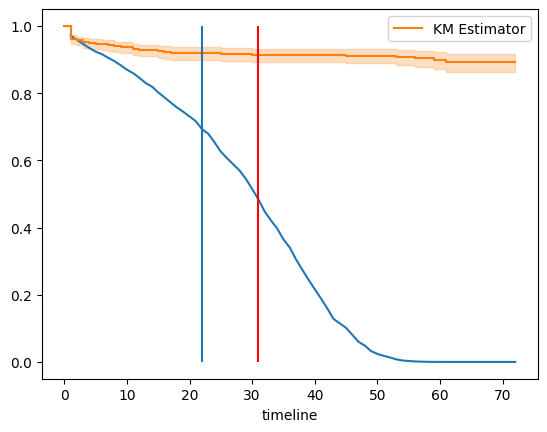

In [ ]:
patient_name = surv_pred_train.columns[1]
pred_median = surv_median_pred_train
ax = surv_pred_train[patient_name].plot()
kmf.plot(ax=ax, label="KM Estimator")
plt.vlines(train_data.loc[patient_name, "time"], ymin=0, ymax=1)
plt.vlines(surv_median_pred_train[patient_name], ymin=0, ymax=1, color="red")
plt.show()

### Test data

In [ ]:
test_data = pd.concat([X_test_mod, y_test], axis=1)

surv_pred_dev = cph.predict_survival_function(test_data)
surv_median_pred_dev = cph.predict_median(test_data)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning:




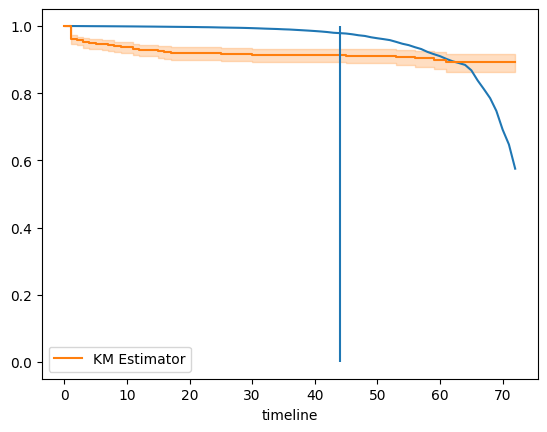

In [ ]:
patient_name = surv_pred_dev.columns[100]
pred_median = surv_median_pred_dev
ax = surv_pred_dev[patient_name].plot()
kmf.plot(ax=ax, label="KM Estimator")
plt.vlines(test_data.loc[patient_name, "time"], ymin=0, ymax=1)
plt.vlines(surv_median_pred_dev[patient_name], ymin=0, ymax=1, color="red")
plt.show()

<Axes: xlabel='timeline'>

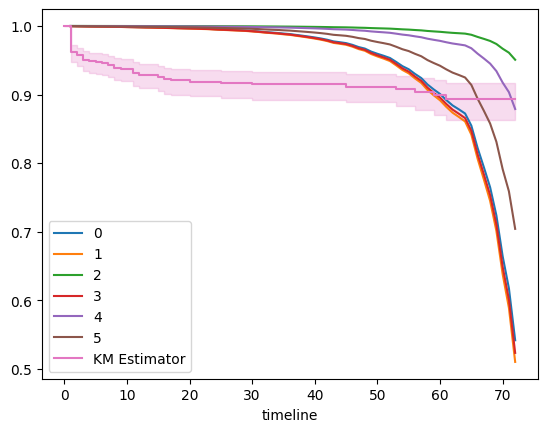

In [ ]:
ax = surv_pred_dev.iloc[:, 0:6].plot();
kmf.plot(ax=ax, label="KM Estimator")
plt.show()

In [ ]:
from lifelines.utils import concordance_index
concordance_index(test_data["time"], -cph.predict_partial_hazard(test_data), test_data["status"])

0.9216882620559035


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4219 total observations, 3097 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic      p  -log2(p)
Dependents_n       km              0.03   0.86      0.22
                   rank            0.01   0.92      0.12
PaperlessBilling_n km              0.98   0.32      1.63
                   rank            0.11   0.75      0.42
Partner_n          km              0.13   0.72      0.48
                   rank            0.00   0.96      0.05
SeniorCitizen_n    km              1.19   0.28      1.86
                   rank            0.08   0.78      0.36
TotalCharges       km            395.57 <0.005    289.99
                   rank          306.58 <0.005    225.61
feature_1          km              4.89   0.03      5.21
                   rank            2.21   0.14      2.86
feature_2          km              7.63   0.01      7.44
                   rank           12.62 <0.005     11.35
feature_3          km              9.73 <0.005      9.11
                   rank            7.79   0.01      7.57
feature_5          km             13.50 <0.005     12.03
                   rank            8.69 <0.005      8.29
feature_6          km              0.33   0.56      0.82
                   rank            0.06   0.81      0.31
feature_9          km             20.78 <0.005     17.57
                   rank           27.04 <0.005     22.26
gender_n           km              2.18   0.14      2.83
                   rank            1.53   0.22      2.21



1. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'TotalCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'TotalCharges' using pd.cut, and then specify it in
`strata=['TotalCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'feature_1' failed the non-proportional test: p-value is

[[<Axes: xlabel='rank-transformed time\n(p=0.7776)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2755)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9633)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7180)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9201)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8575)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7453)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3226)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2163)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1402)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1374)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0269)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0004)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0058)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0053)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0018)'>],
 [<Axes: xlabel='rank-transformed tim

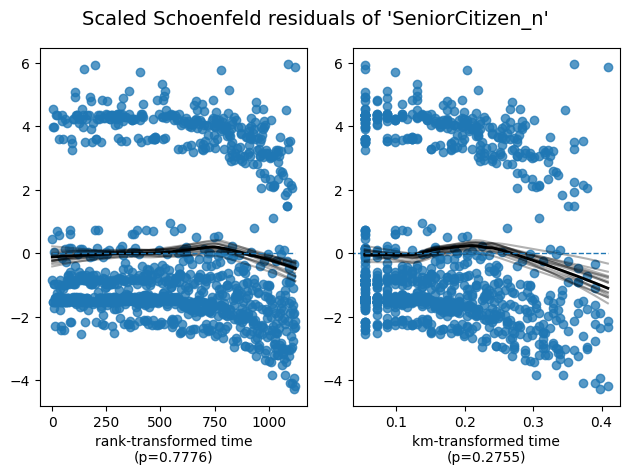

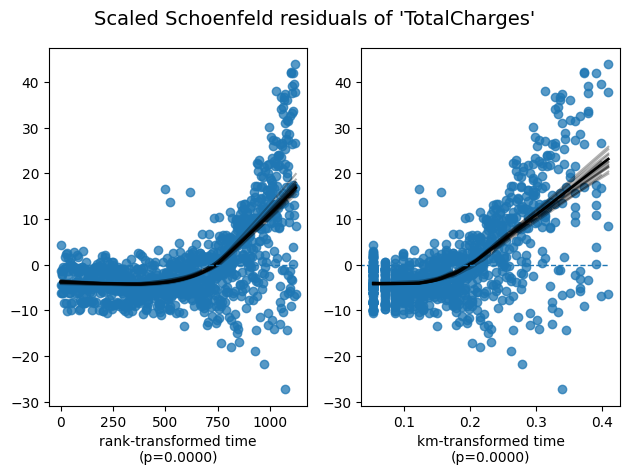

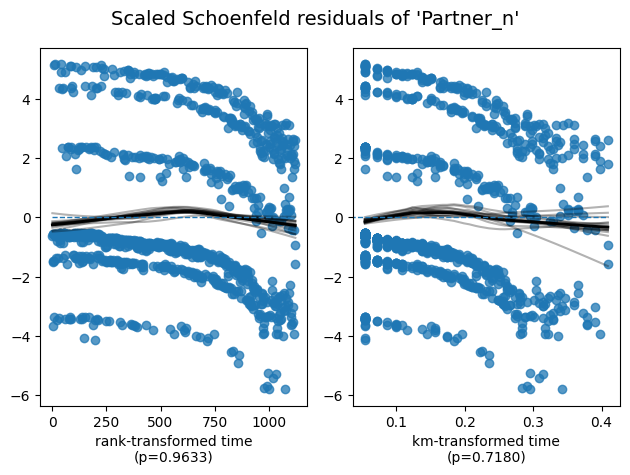

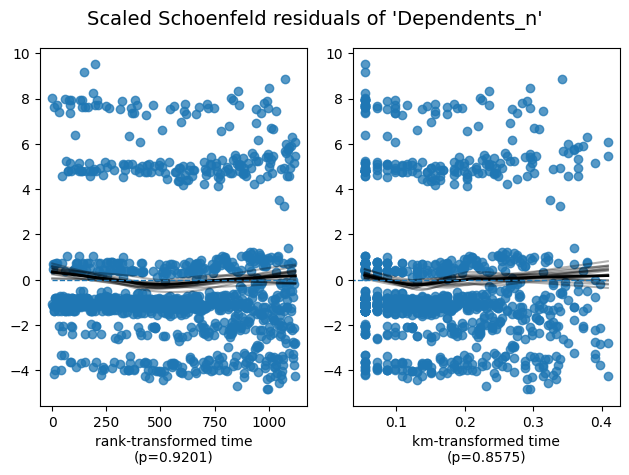

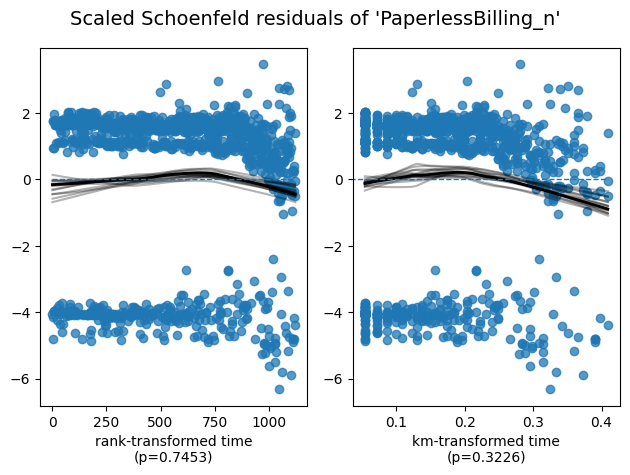

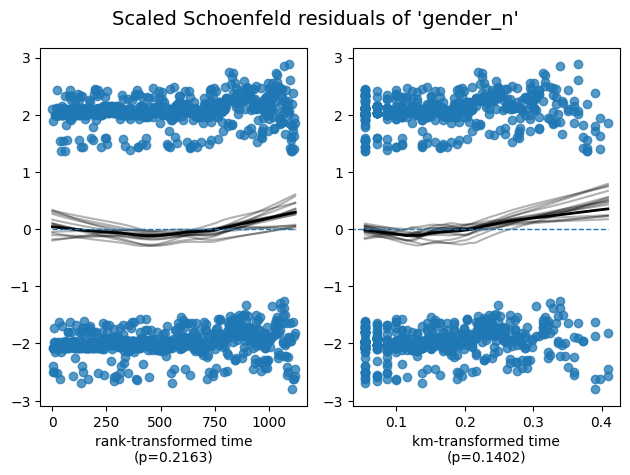

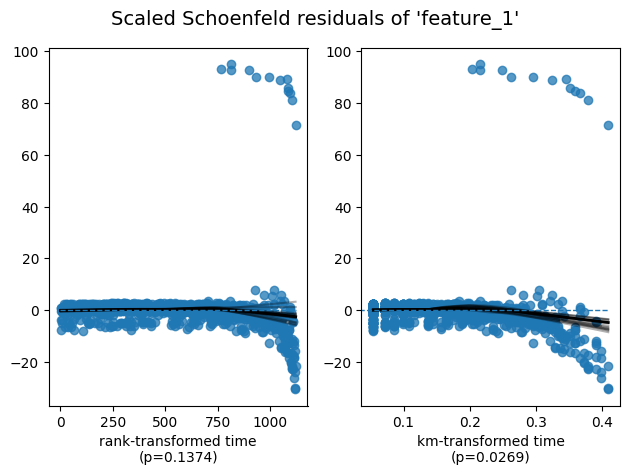

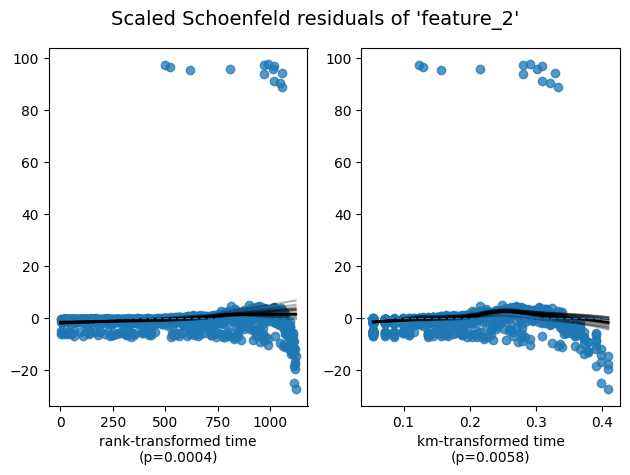

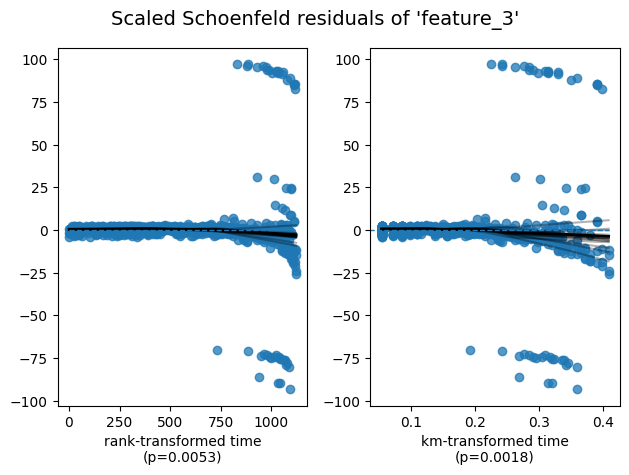

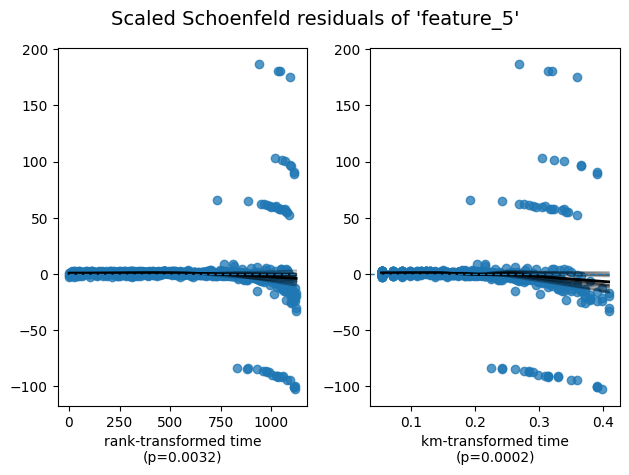

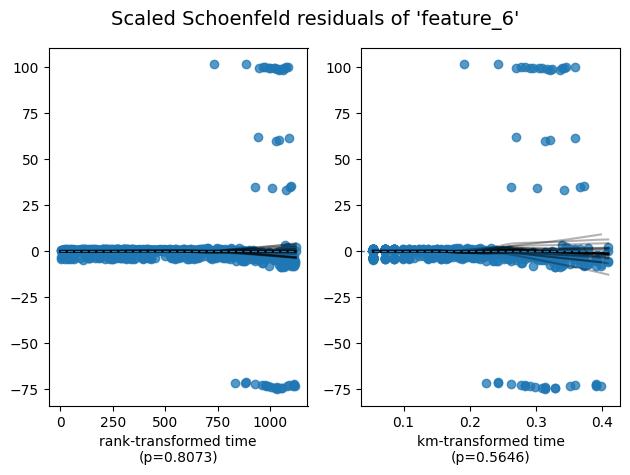

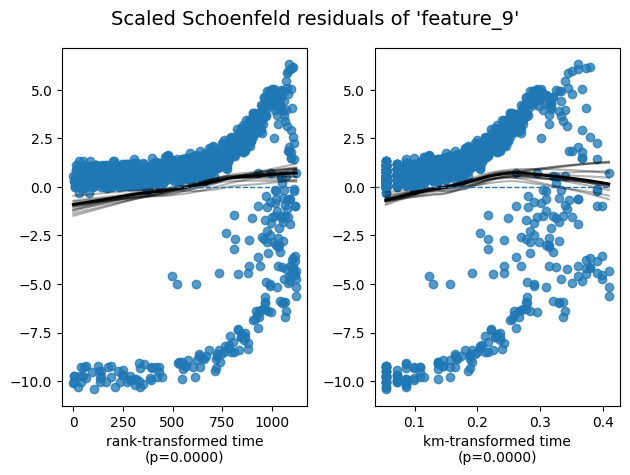

In [ ]:
cph.check_assumptions(train_data.loc[:, to_keep_vif],
                      p_value_threshold=0.05,
                      show_plots=True)

In [ ]:
assumptions_results = lifelines.statistics.proportional_hazard_test(cph,
                                                                    train_data.loc[:, to_keep_vif],
                                                                    time_transform="rank"
)
assumptions_results.print_summary()

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4219 total observations, 3097 right-censored observations>
         test_name = proportional_hazard_test

---
                    test_statistic      p  -log2(p)
Dependents_n                  0.01   0.92      0.12
PaperlessBilling_n            0.11   0.75      0.42
Partner_n                     0.00   0.96      0.05
SeniorCitizen_n               0.08   0.78      0.36
TotalCharges                306.58 <0.005    225.61
feature_1                     2.21   0.14      2.86
feature_2                    12.62 <0.005     11.35
feature_3                     7.79   0.01      7.57
feature_5                     8.69 <0.005      8.29
feature_6                     0.06   0.81      0.31
feature_9                    27.04 <0.005     22.26
gender_n                      1.53   0.22      2.21

### Accelerated Failure Time (AFT) Model

If the proportional hazard assumption criteria of Cox-PH model is not satisfied, in such instance, a better approach is to use a parametric model. Accelerated Failure Time (AFT) is one of the popular parametric model used in survival analysis.

#### Identifying the Best Fitted Distribution
* Import distributions from lifelines library
* Instantiate the class object and save inside a variable. For example, here the Weibull class object has been saved inside “wb”
* Iterate through all model objects and fit with the time and event data
* Print the AIC value
* The distribution with the lowest AIC value presents the best fitted distribution

In [ ]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter

# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = train_data["time"], event_observed = train_data["status"])

    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 12701.18600825704
The AIC value for ExponentialFitter is 13023.943378116492
The AIC value for LogNormalFitter is 12632.182084022976
The AIC value for LogLogisticFitter is 12691.3475907679


In [ ]:
from lifelines import LogNormalAFTFitter

lognormal_aft = LogNormalAFTFitter()
lognormal_aft.fit(train_data.loc[:, to_keep_vif],
                duration_col="time",
                event_col="status")
lognormal_aft.print_summary(3)

<lifelines.LogNormalAFTFitter: fitted with 4219 total observations, 3097 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 4219
number of events observed = 1122
           log-likelihood = -5040.922
         time fit was run = 2024-04-17 13:56:10 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                  
mu_    Dependents_n        0.128      1.136      0.071           -0.011            0.266                0.989                1.305
       PaperlessBilling_n -0.303      0.739      0.059           -0.418           -0.188                0.658                0.829
       Partner_n           0.229      1.257      0.061            0.110            0.348                1.116                1.416
       PhoneService_n     -0.505      0.603      0.090           -0.682           -0.328                0.505                0.721
       SeniorCitizen_n    -0.289      0.749      0.066           -0.419           -0.158                0.658                0.854
       TotalCharges        6.644    768.508      0.152            6.346            6.943              570.288             1035.624
       feature_1           0.895      2.447      0.109            0.681            1.109                1.976                3.030
       feature_2           2.216      9.167      0.079            2.061            2.370                7.853               10.701
       feature_3          -0.390      0.677      0.118           -0.621           -0.160                0.537                0.852
       feature_5          -1.037      0.354      0.219           -1.466           -0.609                0.231                0.544
       feature_6          -0.158      0.854      0.081           -0.317            0.002                0.728                1.002
       gender_n            0.032      1.033      0.052           -0.069            0.134                0.933                1.143
       Intercept           2.414     11.180      0.104            2.211            2.617                9.125               13.698
sigma_ Intercept           0.167      1.182      0.022            0.123            0.210                1.131                1.234

                            cmp to      z       p   -log2(p)
param  covariate                                            
mu_    Dependents_n          0.000  1.807   0.071      3.821
       PaperlessBilling_n    0.000 -5.157 <0.0005     21.926
       Partner_n             0.000  3.772 <0.0005     12.591
       PhoneService_n        0.000 -5.582 <0.0005     25.325
       SeniorCitizen_n       0.000 -4.344 <0.0005     16.126
       TotalCharges          0.000 43.656 <0.0005        inf
       feature_1             0.000  8.204 <0.0005     51.938
       feature_2             0.000 28.058 <0.0005    573.018
       feature_3             0.000 -3.321   0.001     10.124
       feature_5             0.000 -4.742 <0.0005     18.854
       feature_6             0.000 -1.940   0.052      4.254
       gender_n              0.000  0.623   0.533      0.907
       Intercept             0.000 23.298 <0.0005    396.408
sigma_ Intercept             0.000  7.497 <0.0005     43.797
---
Concordance = 0.919
AIC = 10109.844
log-likelihood ratio test = 2546.338 on 12 df
-log2(p) of ll-ratio test = inf

* A unit increase in covariate indicates that the mean/median survival time will change by a factor of exp(coefficient).
* If the coefficient is positive, then the exp(coefficient) will be >1, which will decelerate the incident/event time. Similarly, a negative coefficient will reduce the mean/median survival time.

In [ ]:
print(lognormal_aft.median_survival_time_)
print(lognormal_aft.mean_survival_time_)

14.870574644008016
29.887374966983668


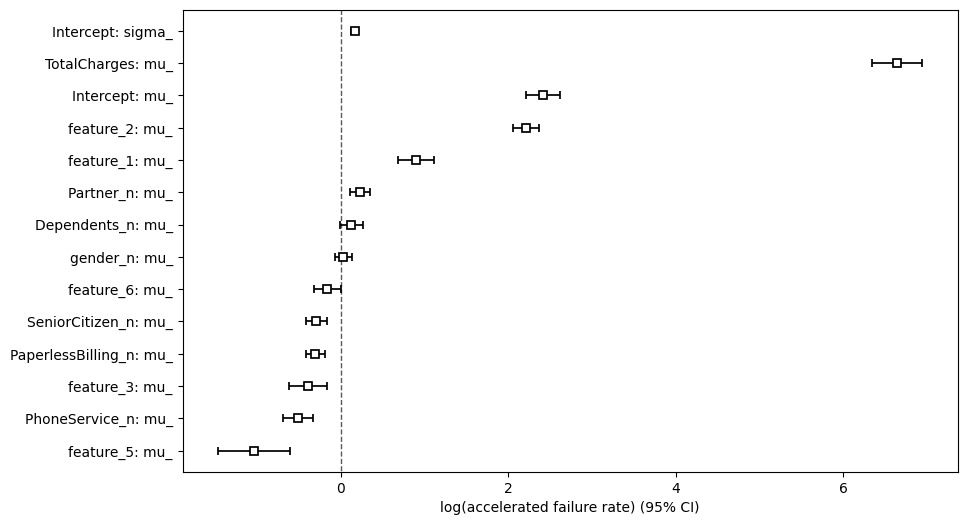

In [ ]:
plt.subplots(figsize=(10, 6))
lognormal_aft.plot()
plt.show()